
# Universidad de las Américas (UDLA)

## Proyecto MBD - Capstone – Maestría en Inteligencia de Negocios y Ciencia de Datos

## Análisis predictivo de la concentración de material particulado fino (PM2.5) en la provincia de Pichincha y Azuay mediante técnicas de machine learning

---

**Autora:** Alyssa Krupskaia Cadena Gómez  
**Objetivo:** Desarrollar modelos de predicción de la concentración de material particulado fino (PM2.5) a nivel provincial  
**Ámbito geográfico:** Provincias de Pichincha y Azuay  
**Estaciones de monitoreo:** Belisario, Carapungo, Edificio Alcaldía Cuenca AT, Colegio Carlos Arízaga Vega  
**Modelos utilizados:** ARIMA, SARIMA, SARIMAX  
**Periodo analizado:** 2005 - 2018

---

Este notebook documenta el flujo completo de trabajo en la construcción de modelos de predicción de PM2.5, desde la exploración y limpieza de datos, hasta la validación y comparación de modelos de series temporales. El análisis se centra en evaluar la capacidad de modelos estadísticos clásicos para anticipar niveles de contaminación atmosférica, con el fin de aportar evidencia técnica útil para la gestión ambiental en contextos urbanos ecuatorianos.

Se presentan métricas de desempeño como MAE, RMSE, R², AIC y BIC.



### 1. Carga y exploración inicial de datos

En esta sección se importa el conjunto de datos desde su fuente original y se realiza una exploración preliminar. Se identifican las variables clave, se reconocen las series temporales por estación y se detectan posibles inconsistencias, vacíos o valores atípicos.


In [3]:
import pandas as pd

# Cargar el archivo CSV con codificación adecuada y separador correcto
file_path = 'concentracionpm25.csv'
df = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1')

# Mostrar las primeras filas del dataset
df.head()

ANIO_REPORT  ANIO  CODMES    MES  DIA  COD_PROV       PROV  COD_CANT  \
0         2021  2005       1  Enero    1        17  Pichincha      1701   
1         2021  2005       1  Enero    2        17  Pichincha      1701   
2         2021  2005       1  Enero    3        17  Pichincha      1701   
3         2021  2005       1  Enero    5        17  Pichincha      1701   
4         2021  2005       1  Enero    6        17  Pichincha      1701   

                              CANT  COD_TIPO        TIPO  COD_EST   ESTACION  \
0  Distrito Metropolitano de Quito         1  Automática        3  Belisario   
1  Distrito Metropolitano de Quito         1  Automática        3  Belisario   
2  Distrito Metropolitano de Quito         1  Automática        3  Belisario   
3  Distrito Metropolitano de Quito         1  Automática        3  Belisario   
4  Distrito Metropolitano de Quito         1  Automática        3  Belisario   

   PM2.5  
0  37,45  
1  29,52  
2  23,77  
3  19,71  
4  21,24

In [5]:
# Ver tipos de datos y dimensiones
df.shape, df.dtypes

((30983, 14),
 ANIO_REPORT     int64
 ANIO            int64
 CODMES          int64
 MES            object
 DIA             int64
 COD_PROV        int64
 PROV           object
 COD_CANT        int64
 CANT           object
 COD_TIPO        int64
 TIPO           object
 COD_EST         int64
 ESTACION       object
 PM2.5          object
 dtype: object)

### 2. Limpieza y transformación de datos
 
Aquí se lleva a cabo el tratamiento de datos faltantes, la conversión de formatos de fecha, la eliminación de duplicados y la estandarización de columnas. También se realiza la selección de variables relevantes (fecha, estación y PM2.5) para asegurar consistencia y calidad en el modelado.


In [7]:
# Reemplazar comas por puntos en PM2.5 y convertir a numérico
df['PM2.5'] = df['PM2.5'].str.replace(',', '.', regex=False)
df['PM2.5'] = pd.to_numeric(df['PM2.5'], errors='coerce')

In [9]:
# Crear columna de fecha combinando ANIO, CODMES y DIA
fecha_temp = df[['ANIO', 'CODMES', 'DIA']].rename(columns={'ANIO': 'year', 'CODMES': 'month', 'DIA': 'day'})
#fecha_temp = df[['ANIO', 'CODMES']].rename(columns={'ANIO': 'year', 'CODMES': 'month'})
df['FECHA'] = pd.to_datetime(fecha_temp, errors='coerce')

In [11]:
df['FECHA']

0       2005-01-01
1       2005-01-02
2       2005-01-03
3       2005-01-05
4       2005-01-06
           ...    
30978   2018-12-27
30979   2018-12-28
30980   2018-12-29
30981   2018-12-30
30982   2018-12-31
Name: FECHA, Length: 30983, dtype: datetime64[ns]

In [13]:
# Verificar valores faltantes en todo el dataset
df.isnull().sum()

ANIO_REPORT     0
ANIO            0
CODMES          0
MES             0
DIA             0
COD_PROV        0
PROV            0
COD_CANT        0
CANT            0
COD_TIPO        0
TIPO            0
COD_EST         0
ESTACION        0
PM2.5          27
FECHA           0
dtype: int64

In [15]:
# Ver filas con valores faltantes en PM2.5
df[df['PM2.5'].isnull()]

ANIO_REPORT  ANIO  CODMES         MES  DIA  COD_PROV       PROV  \
27318         2021  2018       2     Febrero   10         1      Azuay   
27319         2021  2018       2     Febrero   11         1      Azuay   
27320         2021  2018       2     Febrero   12         1      Azuay   
27321         2021  2018       2     Febrero   13         1      Azuay   
27322         2021  2018       2     Febrero   14         1      Azuay   
27368         2021  2018       2     Febrero    4        17  Pichincha   
27621         2021  2018       3       Marzo    5         1      Azuay   
27622         2021  2018       3       Marzo    6         1      Azuay   
27833         2021  2018       3       Marzo   31        17  Pichincha   
28138         2021  2018       4       Abril    1        17  Pichincha   
28472         2021  2018       5        Mayo   30        17  Pichincha   
28473         2021  2018       5        Mayo   31        17  Pichincha   
28486         2021  2018       5        Mayo   13        17  Pichincha   
28686         2021  2018       6       Junio   28         1      Azuay   
29754         2021  2018       9  Septiembre   24        17  Pichincha   
29799         2021  2018       9  Septiembre    9        17  Pichincha   
29829         2021  2018       9  Septiembre    9        17  Pichincha   
29976         2021  2018      10     Octubre    6         1      Azuay   
29989         2021  2018      10     Octubre   19         1      Azuay   
30001         2021  2018      10     Octubre   31         1      Azuay   
30256         2021  2018      10     Octubre    7        17  Pichincha   
30257         2021  2018      10     Octubre    8        17  Pichincha   
30552         2021  2018      11   Noviembre    1        17  Pichincha   
30553         2021  2018      11   Noviembre    2        17  Pichincha   
30554         2021  2018      11   Noviembre    3        17  Pichincha   
30555         2021  2018      11   Noviembre    4        17  Pichincha   
30556         2021  2018      11   Noviembre    5        17  Pichincha   

       COD_CANT                             CANT  COD_TIPO        TIPO  \
27318       101                           Cuenca         1  Automática   
27319       101                           Cuenca         1  Automática   
27320       101                           Cuenca         1  Automática   
27321       101                           Cuenca         1  Automática   
27322       101                           Cuenca         1  Automática   
27368      1701  Distrito Metropolitano de Quito         1  Automática   
27621       101                           Cuenca         1  Automática   
27622       101                           Cuenca         1  Automática   
27833      1701  Distrito Metropolitano de Quito         1  Automática   
28138      1701  Distrito Metropolitano de Quito         1  Automática   
28472      1701  Distrito Metropolitano de Quito         1  Automática   
28473      1701  Distrito Metropolitano de Quito         1  Automática   
28486      1701  Distrito Metropolitano de Quito         1  Automática   
28686       101                           Cuenca         1  Automática   
29754      1701  Distrito Metropolitano de Quito         1  Automática   
29799      1701  Distrito Metropolitano de Quito         1  Automática   
29829      1701  Distrito Metropolitano de Quito         1  Automática   
29976       101                           Cuenca         1  Automática   
29989       101                           Cuenca         1  Automática   
30001       101                           Cuenca         1  Automática   
30256      1701  Distrito Metropolitano de Quito         1  Automática   
30257      1701  Distrito Metropolitano de Quito         1  Automática   
30552      1701  Distrito Metropolitano de Quito         1  Automática   
30553      1701  Distrito Metropolitano de Quito         1  Automática   
30554      1701  Distrito Metropolitano de Quito         1  Automática   
30555     

In [8]:
# Codificar variables categóricas usando one-hot encoding
#cat_cols = ['MES', 'PROV', 'CANT', 'TIPO', 'ESTACION']
#df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [9]:
# Eliminar columnas no necesarias para el modelo
#df_encoded = df_encoded.drop(columns=['ANIO_REPORT', 'FECHA'])

In [10]:
# Separar variables predictoras (X) y objetivo (y)
#X = df_encoded.drop(columns=['PM2.5'])
#y = df_encoded['PM2.5']

In [11]:
# Mostrar resumen final
#print('X shape:', X.shape)
#print('y shape:', y.shape)
#print('Valores nulos en y:', y.isnull().sum())

In [17]:
cod_nombre_estaciones = df[['COD_EST', 'ESTACION']].drop_duplicates().sort_values(by='COD_EST')

In [19]:
cod_nombre_estaciones


COD_EST                        ESTACION
233          1                      Cotocollao
243          2                       Carapungo
0            3                       Belisario
30           4                        El Camal
61           5                          Centro
23999        6                         Guamani
27185        6                         Guamaní
16520        7                     Los Chillos
24055        8                         Tumbaco
92           9                        Jipijapa
20961       12                     San_Antonio
27278       12        San Antonio de Pichincha
14662       32  Edificio Alcaldia de Cuenca AT
21799       35     Colegio Carlos Arizaga Vega
26999       35     Colegio Carlos Arízaga Vega

In [21]:
# Diccionario de homologación por código
homologacion_por_codigo = {
    1: 'Cotocollao',
    2: 'Carapungo',
    3: 'Belisario',
    4: 'El Camal',
    5: 'Centro',
    6: 'Guamaní',  # Unifica Guamani y Guamaní
    7: 'Los Chillos',
    8: 'Tumbaco',
    9: 'Jipijapa',
    12: 'San Antonio de Pichincha',  # Unifica San_Antonio y San Antonio de Pichincha
    32: 'Edificio Alcaldía de Cuenca AT',
    35: 'Colegio Carlos Arízaga Vega'  # Unifica duplicados
}

# Aplicar la homologación directamente sobre la misma columna
df['ESTACION'] = df['COD_EST'].map(homologacion_por_codigo).fillna(df['ESTACION'])


In [23]:
cod_nombre_estaciones = df[['COD_EST', 'ESTACION']].drop_duplicates().sort_values(by='COD_EST')
cod_nombre_estaciones

COD_EST                        ESTACION
233          1                      Cotocollao
243          2                       Carapungo
0            3                       Belisario
30           4                        El Camal
61           5                          Centro
23999        6                         Guamaní
16520        7                     Los Chillos
24055        8                         Tumbaco
92           9                        Jipijapa
20961       12        San Antonio de Pichincha
14662       32  Edificio Alcaldía de Cuenca AT
21799       35     Colegio Carlos Arízaga Vega

In [25]:
#tratamiento de valores perdidos y outliers
from scipy.stats.mstats import winsorize

# Imputar valores perdidos con la mediana
mediana_pm25 = df['PM2.5'].median()
df['PM2.5'] = df['PM2.5'].fillna(mediana_pm25)

# Aplicar winsorización (corrigiendo el warning de máscara)
df['PM2.5'] = pd.Series(winsorize(df['PM2.5'].values, limits=[0.01, 0.01]))


In [27]:
# Verificar valores faltantes en todo el dataset
df.isnull().sum()

ANIO_REPORT    0
ANIO           0
CODMES         0
MES            0
DIA            0
COD_PROV       0
PROV           0
COD_CANT       0
CANT           0
COD_TIPO       0
TIPO           0
COD_EST        0
ESTACION       0
PM2.5          0
FECHA          0
dtype: int64

In [29]:
# Ver tipos de datos y dimensiones
df.shape, df.dtypes

((30983, 15),
 ANIO_REPORT             int64
 ANIO                    int64
 CODMES                  int64
 MES                    object
 DIA                     int64
 COD_PROV                int64
 PROV                   object
 COD_CANT                int64
 CANT                   object
 COD_TIPO                int64
 TIPO                   object
 COD_EST                 int64
 ESTACION               object
 PM2.5                 float64
 FECHA          datetime64[ns]
 dtype: object)


### 3. Análisis exploratorio
 
Se analiza el comportamiento temporal de la concentración de PM2.5 por estación. Se generan gráficos de tendencia, distribución, autocorrelación (ACF) y autocorrelación parcial (PACF) para evaluar la presencia de estacionalidad, ciclos, tendencia o ruido en los datos.


In [31]:
from statsmodels.tsa.stattools import adfuller

# Asegúrate de que FECHA esté en formato datetime
df['FECHA'] = pd.to_datetime(df['FECHA'])

# Agrupar por fecha si hay más de un valor diario por estación
serie_pm25 = df.groupby('FECHA')['PM2.5'].mean()

# Aplicar prueba Dickey-Fuller
resultado_adf = adfuller(serie_pm25.dropna())

print("ADF Statistic:", resultado_adf[0])
print("p-valor:", resultado_adf[1])
print("Valores críticos:")
for key, value in resultado_adf[4].items():
    print(f'   {key}: {value}')


ADF Statistic: -5.575318660906601
p-valor: 1.436553120639019e-06
Valores críticos:
   1%: -3.4316381685490334
   5%: -2.862109233152359
   10%: -2.56707300316236


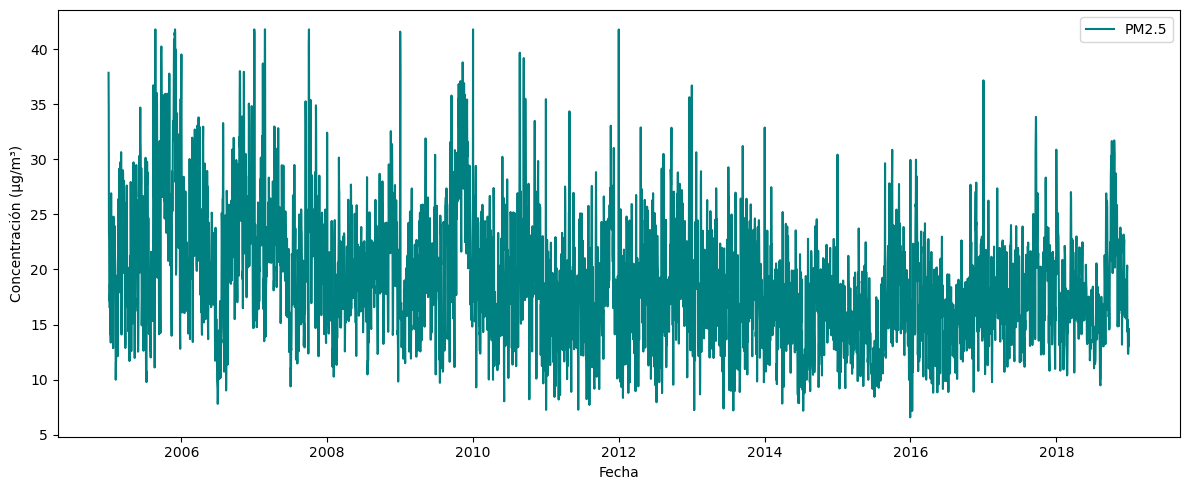

In [33]:
import matplotlib.pyplot as plt

# Asegúrate de que la serie esté con índice datetime y sin nulos
serie_pm25 = df.groupby('FECHA')['PM2.5'].mean().asfreq('D')

# Graficar la serie
plt.figure(figsize=(12, 5))
plt.plot(serie_pm25, label='PM2.5', color='teal')
#plt.title('Serie temporal de concentración diaria de PM2.5')
plt.xlabel('Fecha')
plt.ylabel('Concentración (µg/m³)')
plt.grid(False)
plt.legend()
plt.tight_layout()

plt.savefig("Serie temporal de concentración diaria de PM25.png", dpi=300, bbox_inches='tight')  # también puedes usar .jpg o .pdf

plt.show()

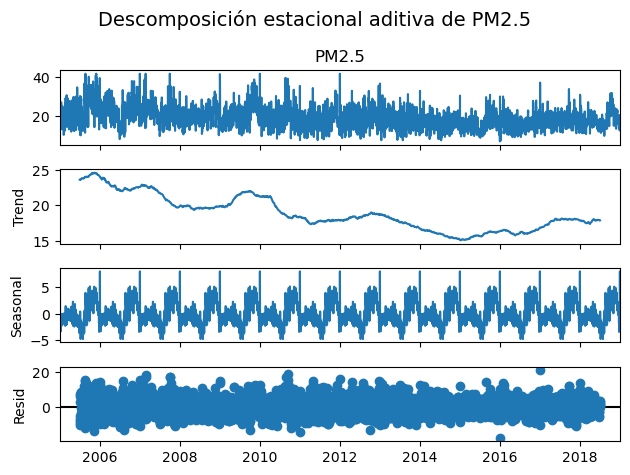

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Descomponer la serie (modelo aditivo, periodo = 365 días)
decomp = seasonal_decompose(serie_pm25, model='additive', period=365)

# Mostrar componentes
decomp.plot()
plt.suptitle('Descomposición estacional aditiva de PM2.5', fontsize=14)
plt.tight_layout()
plt.show()


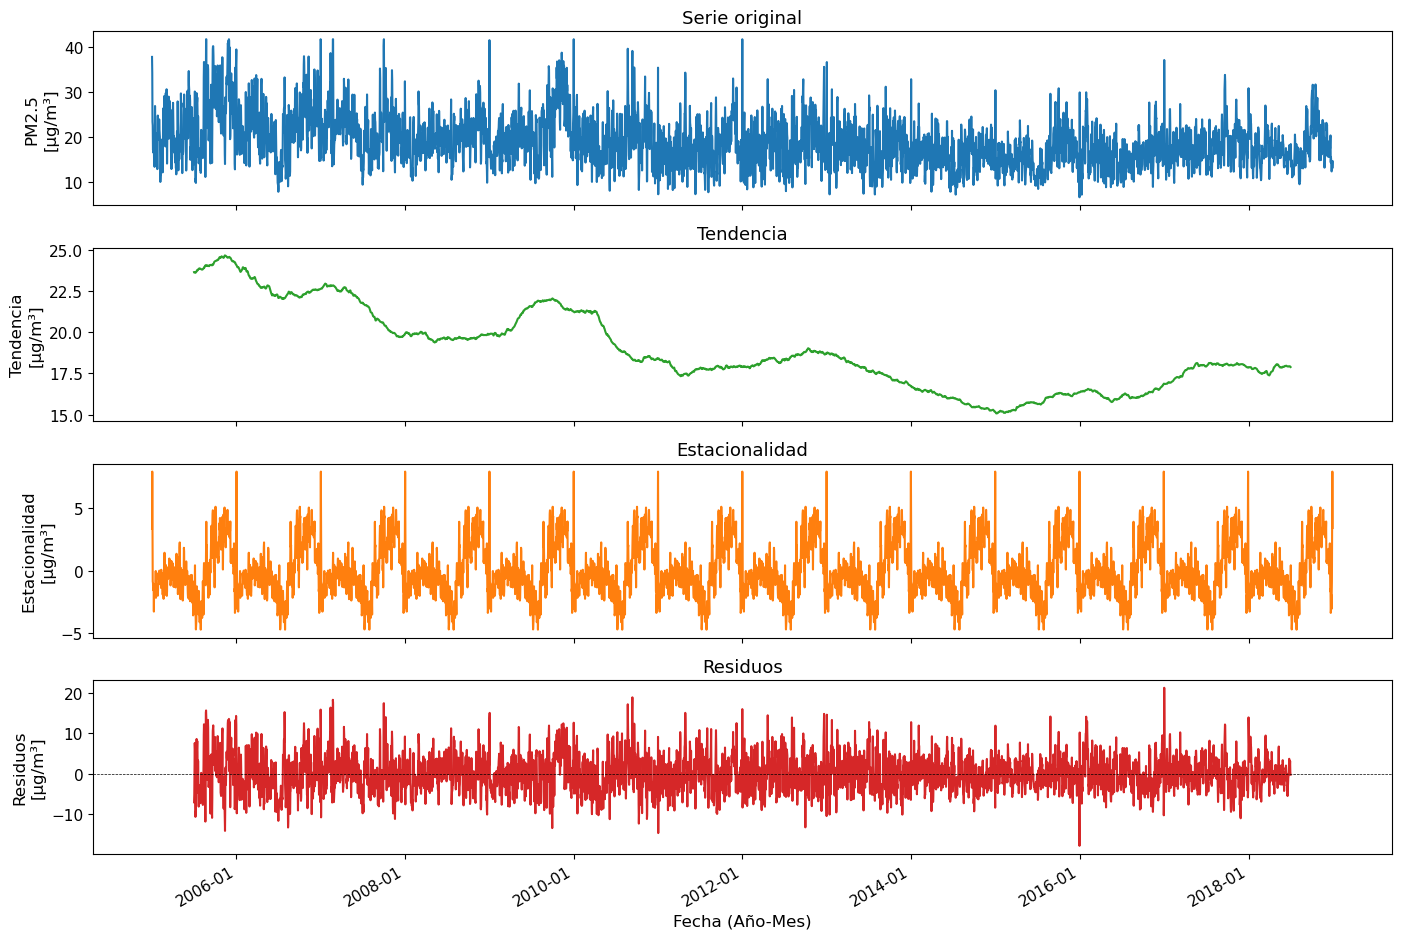

In [39]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de la serie
result = seasonal_decompose(serie_pm25, model='additive', period=365)

# Crear subgráficos
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Formato de fecha
date_format = mdates.DateFormatter("%Y-%m")
axs[3].xaxis.set_major_formatter(date_format)  # último eje (residuos)

# Plot de componentes con etiquetas personalizadas
axs[0].plot(result.observed, color='tab:blue')
axs[0].set_ylabel("PM2.5\n[μg/m³]", fontsize=12)
axs[0].set_title("Serie original", fontsize=13)
axs[0].tick_params(labelsize=11)

axs[1].plot(result.trend, color='tab:green')
axs[1].set_ylabel("Tendencia\n[μg/m³]", fontsize=12)
axs[1].set_title("Tendencia", fontsize=13)
axs[1].tick_params(labelsize=11)

axs[2].plot(result.seasonal, color='tab:orange')
axs[2].set_ylabel("Estacionalidad\n[μg/m³]", fontsize=12)
axs[2].set_title("Estacionalidad", fontsize=13)
axs[2].tick_params(labelsize=11)

axs[3].plot(result.resid, color='tab:red')
axs[3].axhline(0, color='black', linewidth=0.5, linestyle='--')
axs[3].set_ylabel("Residuos\n[μg/m³]", fontsize=12)
axs[3].set_title("Residuos", fontsize=13)
axs[3].tick_params(labelsize=11)
axs[3].set_xlabel("Fecha (Año-Mes)", fontsize=12)

# Título general
#fig.suptitle("Descomposición estacional aditiva de PM2.5", fontsize=16)

# Ajustar márgenes y formato de fechas
fig.autofmt_xdate()
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Guardar o mostrar
plt.savefig("descomposicion_pm25_etiquetada.png", dpi=300)
plt.show()



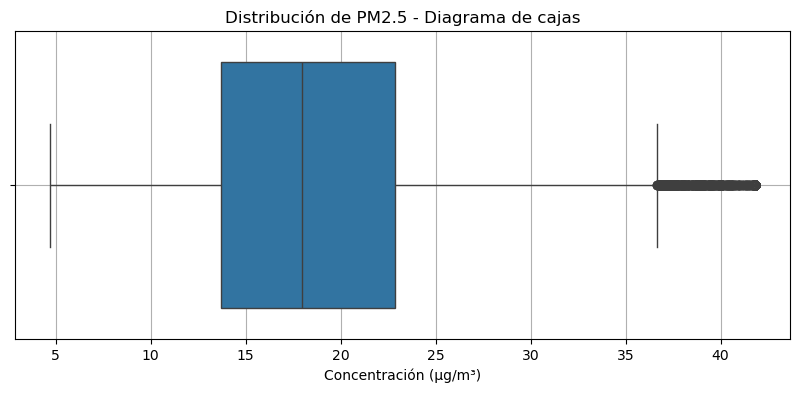

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
sns.boxplot(x=df['PM2.5'])
plt.title('Distribución de PM2.5 - Diagrama de cajas')
plt.xlabel('Concentración (µg/m³)')
plt.grid(True)
plt.show()


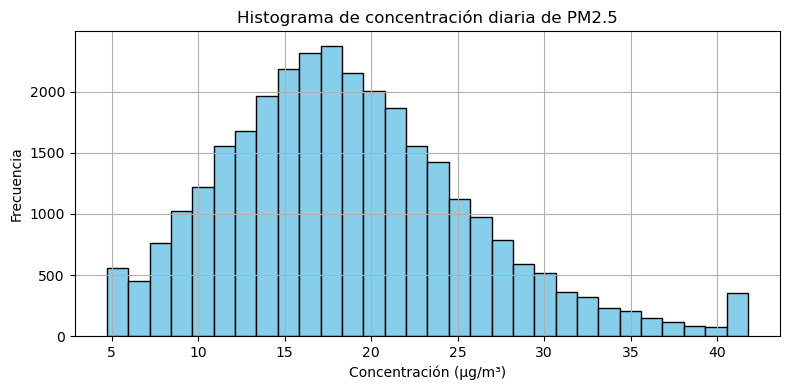

In [43]:
import matplotlib.pyplot as plt

# Histograma de PM2.5
plt.figure(figsize=(8, 4))
plt.hist(df['PM2.5'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma de concentración diaria de PM2.5')
plt.xlabel('Concentración (µg/m³)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.tight_layout()
plt.show()


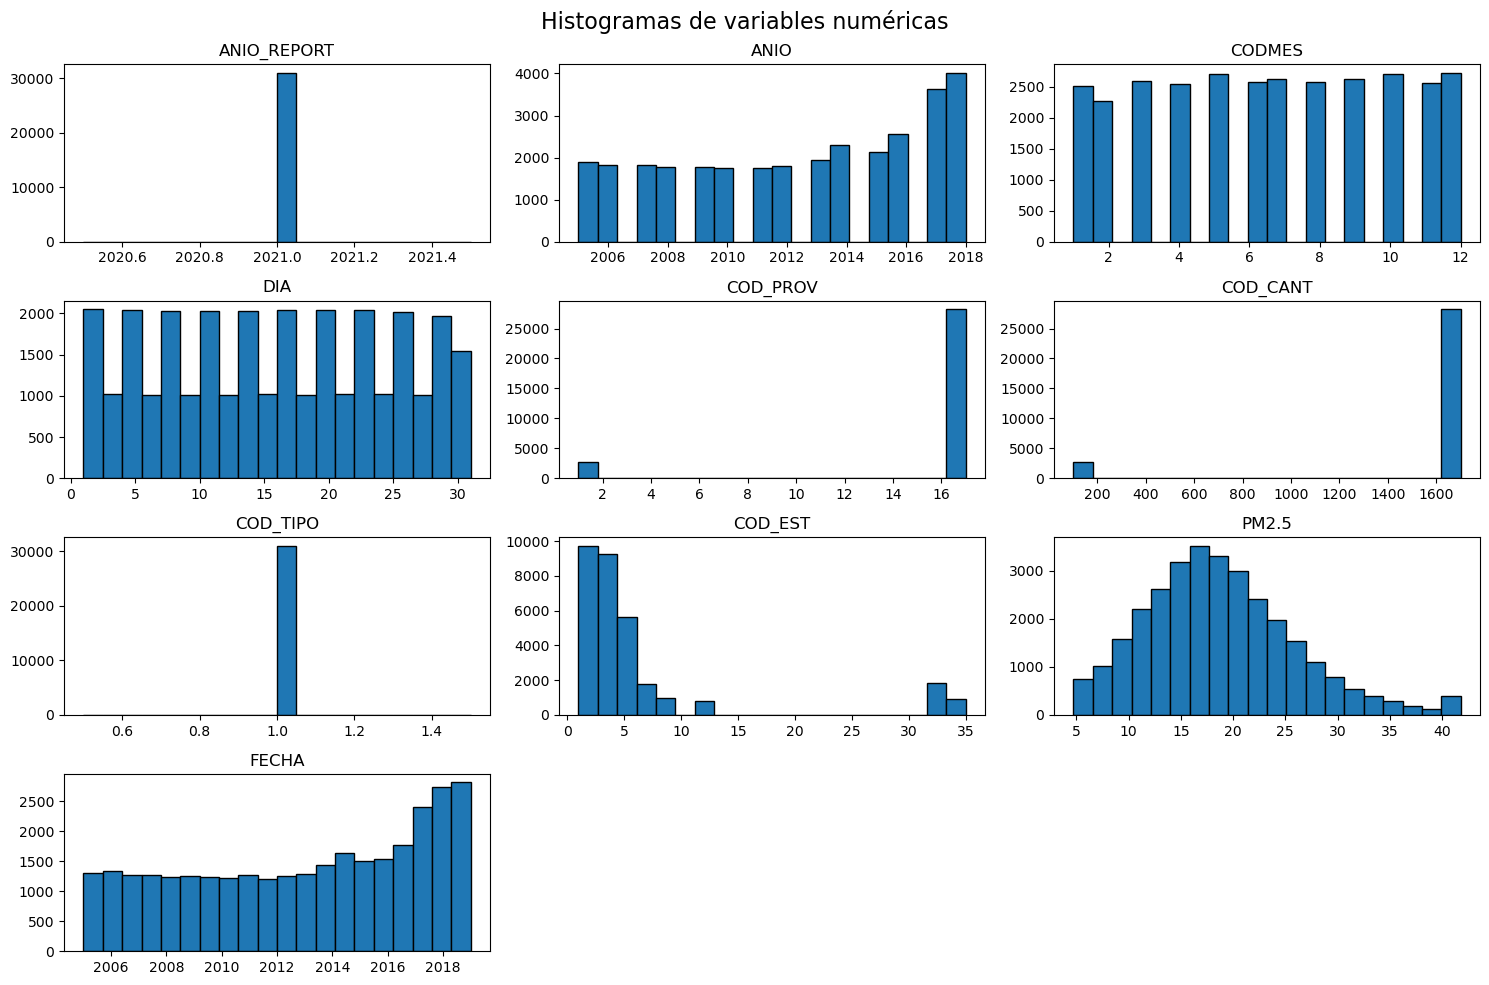

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Ajusta el tamaño global del gráfico
df.hist(figsize=(15, 10), bins=20, edgecolor='black', grid=False)
plt.suptitle('Histogramas de variables numéricas', fontsize=16)
plt.tight_layout()
plt.show()


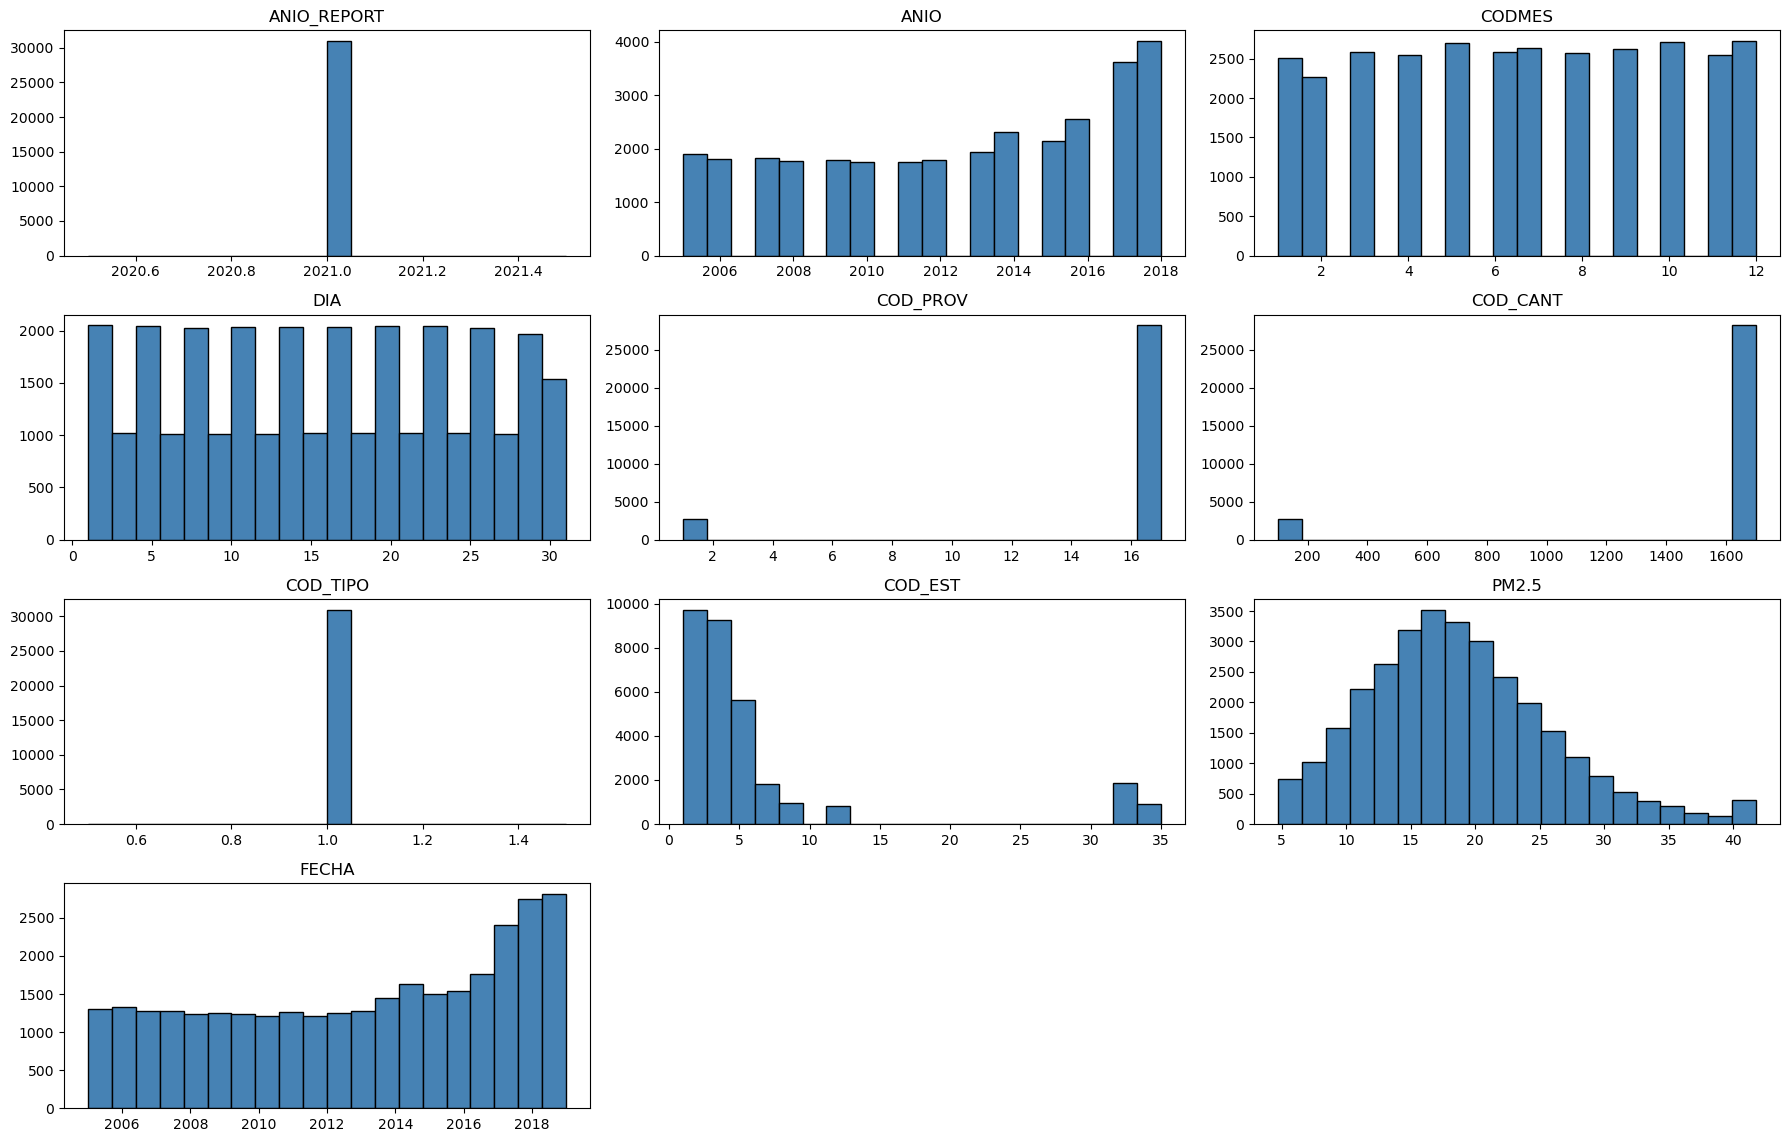

In [344]:
import matplotlib.pyplot as plt

# Lista de columnas numéricas que quieres graficar
columnas = ['ANIO_REPORT', 'ANIO', 'CODMES', 'DIA', 'COD_PROV',
            'COD_CANT', 'COD_TIPO', 'COD_EST', 'PM2.5', 'FECHA']

# Número de filas y columnas para los subgráficos
filas = 4
columnas_graf = 3

# Crear figura grande
fig, axs = plt.subplots(filas, columnas_graf, figsize=(18, 12))
axs = axs.flatten()  # para recorrer fácilmente

# Graficar cada histograma
for i, col in enumerate(columnas):
    axs[i].hist(df[col].dropna(), bins=20, color='steelblue', edgecolor='black')
    axs[i].set_title(col, fontsize=12)
    axs[i].tick_params(labelsize=10)

# Eliminar subgráficos vacíos si hay menos columnas que subplots
for j in range(len(columnas), len(axs)):
    fig.delaxes(axs[j])

# Título general
#fig.suptitle('Histogramas de variables numéricas', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # ajusta para que no se solape el título

# Guardar o mostrar
plt.savefig("histogramas_mejorados.png", dpi=300)
plt.show()


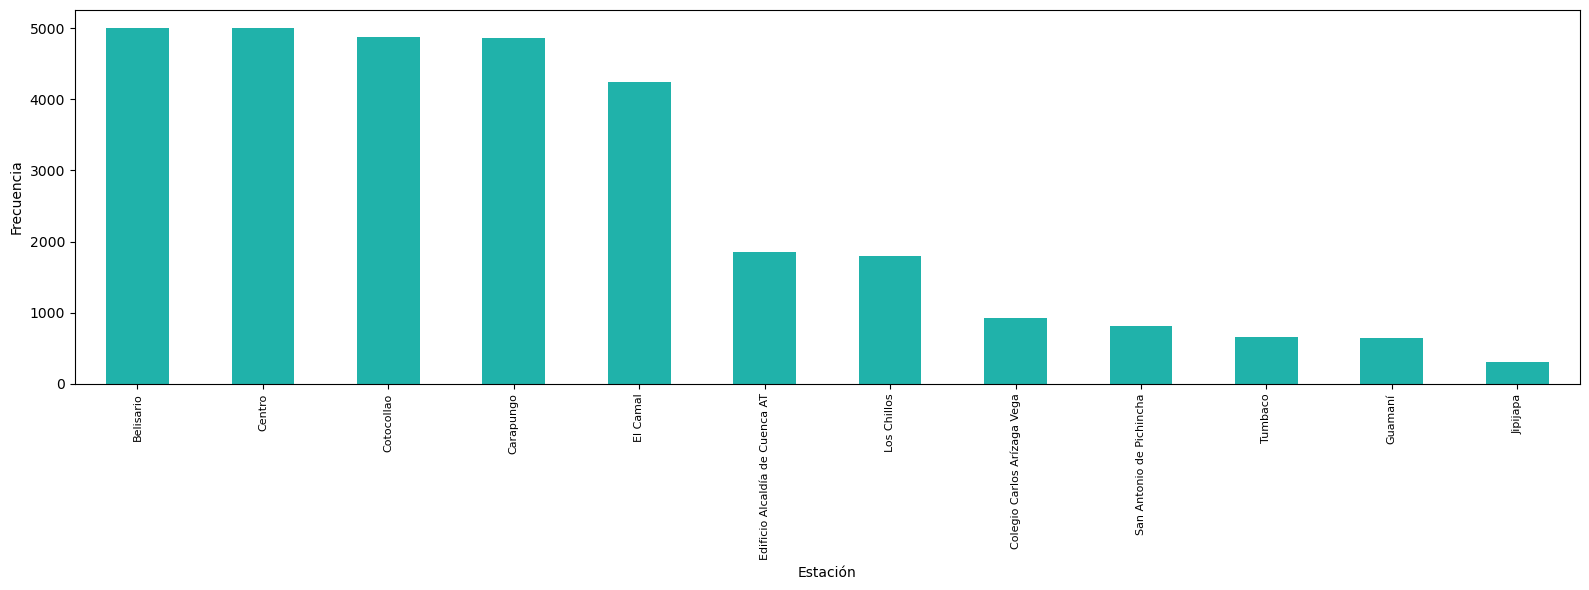

In [350]:
 import matplotlib.pyplot as plt

# Contar ocurrencias por estación
frecuencia_estaciones = df['ESTACION'].value_counts().sort_values(ascending=False)

# Graficar
plt.figure(figsize=(16, 6))
frecuencia_estaciones.plot(kind='bar', color='lightseagreen')

#plt.title('Frecuencia de registros por estación de monitoreo', fontsize=14)
plt.xlabel('Estación')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(False)
plt.tight_layout()
plt.savefig("frecuencia_registros_estacion.png", dpi=300)
plt.show()


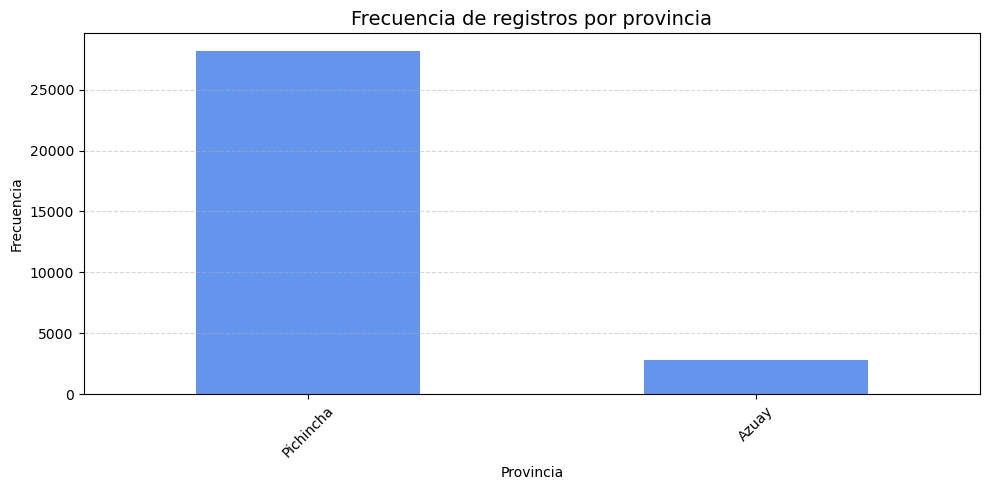

In [54]:
frecuencia_provincias = df['PROV'].value_counts()

plt.figure(figsize=(10, 5))
frecuencia_provincias.plot(kind='bar', color='cornflowerblue')

plt.title('Frecuencia de registros por provincia', fontsize=14)
plt.xlabel('Provincia')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


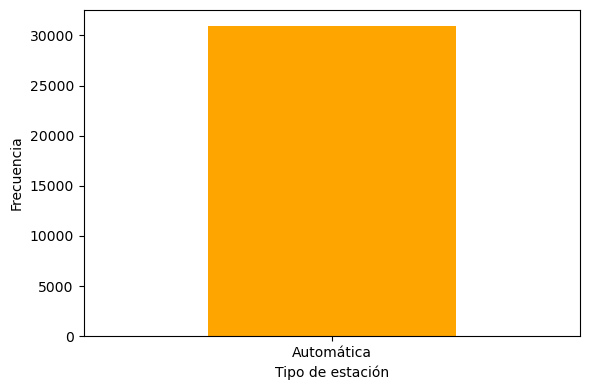

In [356]:
frecuencia_tipos = df['TIPO'].value_counts()

plt.figure(figsize=(6, 4))
frecuencia_tipos.plot(kind='bar', color='orange')

#plt.title('Frecuencia por tipo de estación', fontsize=12)
plt.xlabel('Tipo de estación')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.grid(False)
plt.savefig("frecuencia_tipo_estacion.png", dpi=300)
plt.show()


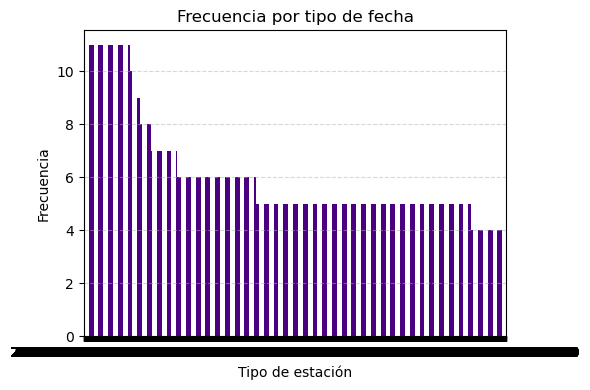

In [77]:
frecuencia_tipos = df['FECHA'].value_counts()

plt.figure(figsize=(6, 4))
frecuencia_tipos.plot(kind='bar', color='indigo')

plt.title('Frecuencia por tipo de fecha', fontsize=12)
plt.xlabel('Tipo de estación')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

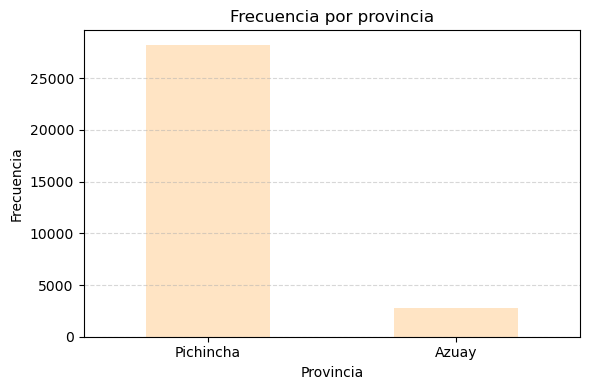

In [78]:
frecuencia_tipos = df['PROV'].value_counts()

plt.figure(figsize=(6, 4))
frecuencia_tipos.plot(kind='bar', color='bisque')

plt.title('Frecuencia por provincia', fontsize=12)
plt.xlabel('Provincia')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

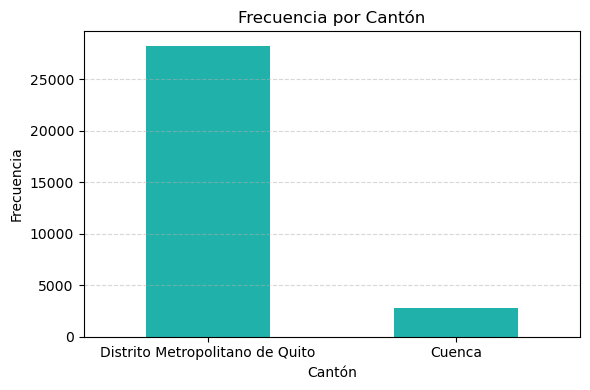

In [75]:
frecuencia_tipos = df['CANT'].value_counts()

plt.figure(figsize=(6, 4))
frecuencia_tipos.plot(kind='bar', color='lightseagreen')

plt.title('Frecuencia por Cantón', fontsize=12)
plt.xlabel('Cantón')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [81]:
# Contar cuántos registros hay por cada provincia
distribucion = df['PROV'].value_counts().reset_index()
distribucion.columns = ['PROVINCIA', 'CANTIDAD_EVENTOS']


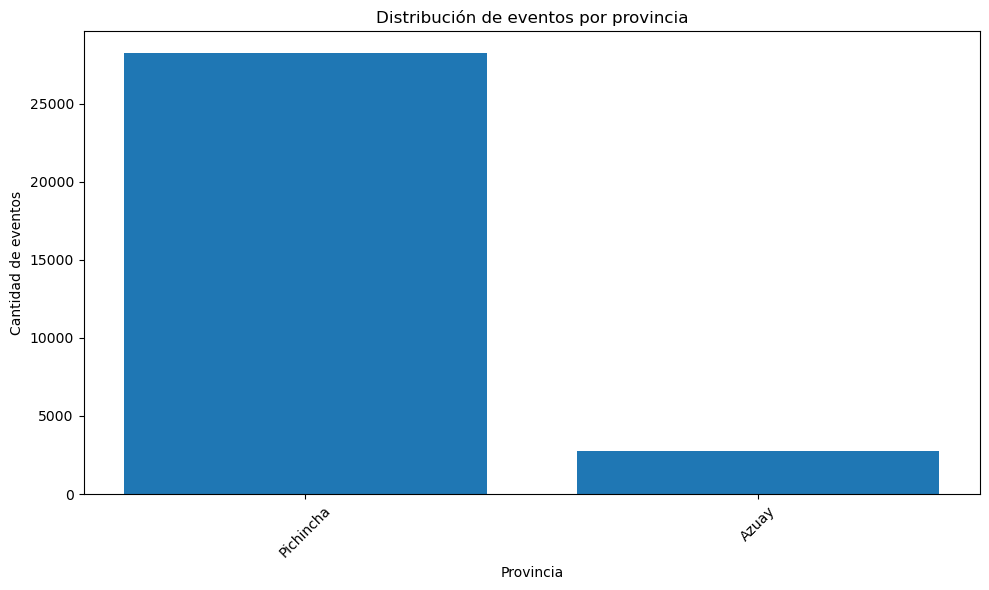

In [83]:
import matplotlib.pyplot as plt

# Crear gráfico
plt.figure(figsize=(10, 6))
plt.bar(distribucion['PROVINCIA'], distribucion['CANTIDAD_EVENTOS'])
plt.title('Distribución de eventos por provincia')
plt.xlabel('Provincia')
plt.ylabel('Cantidad de eventos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 4. Preparación para modelado
  
Se segmentan las series temporales por estación y se divide el conjunto de datos en periodos de entrenamiento y validación. Se realiza diferenciación (cuando es necesario) para asegurar la estacionariedad de las series.


In [45]:
# Contar registros por provincia y estación
distribucion = df.groupby(['PROV', 'ESTACION']).size().reset_index(name='CANTIDAD_EVENTOS')


In [47]:
# Ordenar de mayor a menor
distribucion = distribucion.sort_values(by='CANTIDAD_EVENTOS', ascending=False)

# Mostrar tabla
distribucion.head(10)  # o display(distribucion) en Jupyter


PROV                        ESTACION  CANTIDAD_EVENTOS
2   Pichincha                       Belisario              5006
4   Pichincha                          Centro              4999
5   Pichincha                      Cotocollao              4878
3   Pichincha                       Carapungo              4860
6   Pichincha                        El Camal              4246
1       Azuay  Edificio Alcaldía de Cuenca AT              1846
9   Pichincha                     Los Chillos              1796
0       Azuay     Colegio Carlos Arízaga Vega               922
10  Pichincha        San Antonio de Pichincha               818
11  Pichincha                         Tumbaco               659

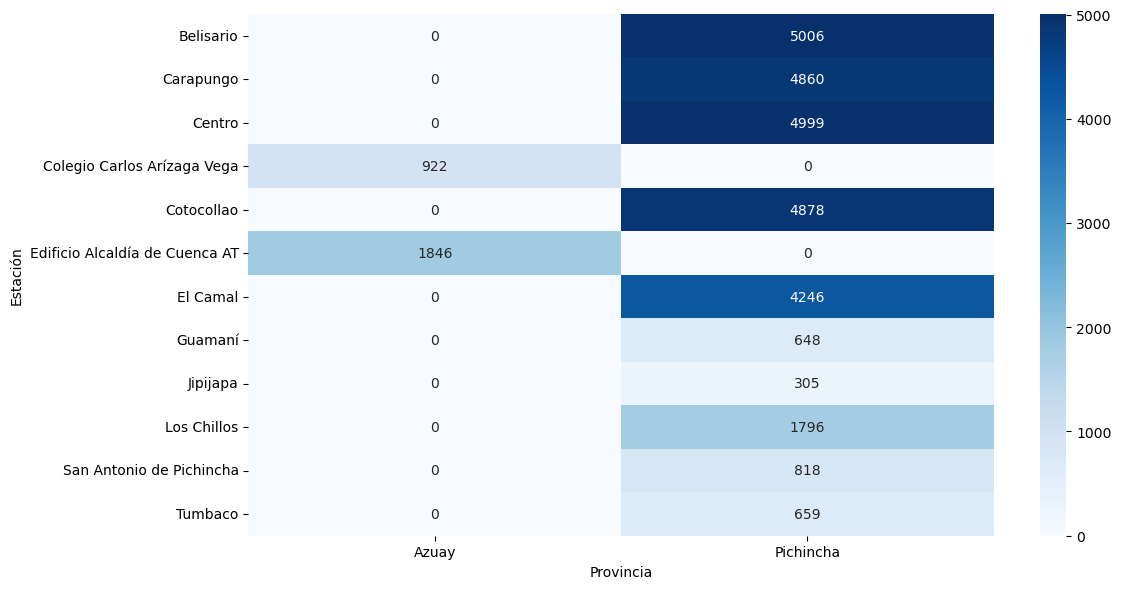

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivotear para gráfico de calor
pivot = distribucion.pivot(index='ESTACION', columns='PROV', values='CANTIDAD_EVENTOS').fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="Blues")
#plt.title('Distribución de eventos por provincia y estación')
plt.xlabel('Provincia')
plt.ylabel('Estación')
plt.tight_layout()

# Guardar o mostrar
plt.savefig("distribucion_eventos.png", dpi=300)
plt.show()


In [93]:
# Crear una columna con año y mes
df['ANIO_MES'] = df['FECHA'].dt.to_period('M').dt.to_timestamp()

# Contar eventos por provincia y mes
tendencia = df.groupby(['ANIO_MES', 'PROV']).size().reset_index(name='EVENTOS')


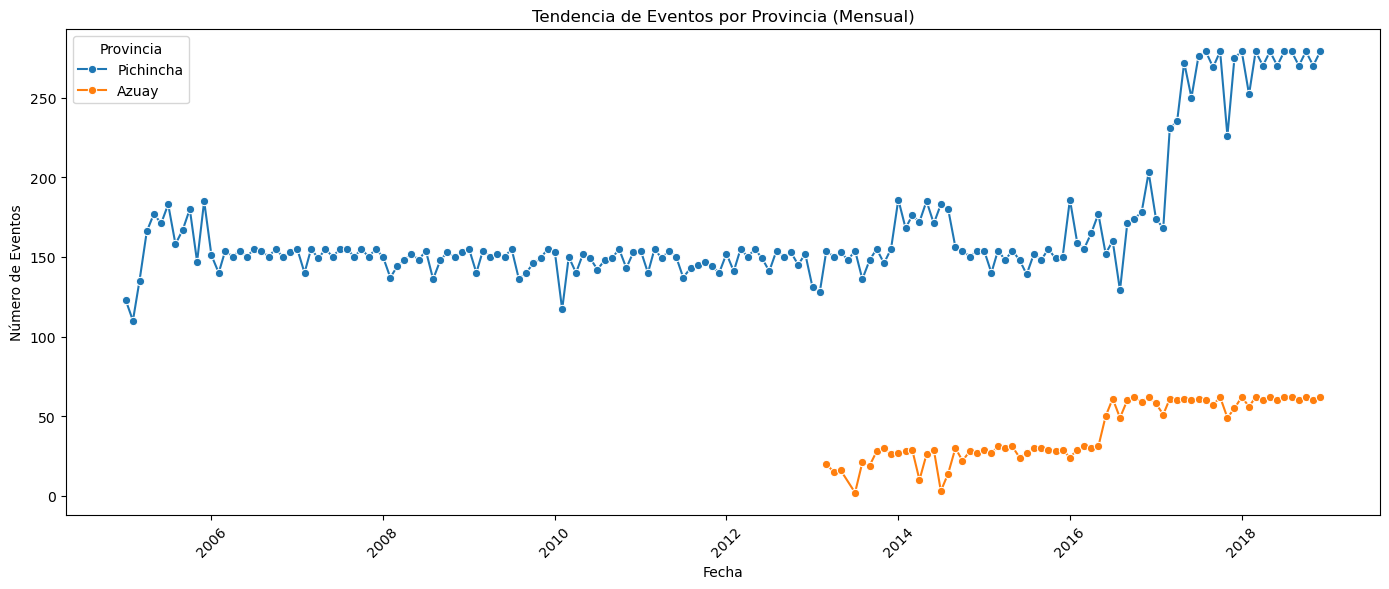

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.lineplot(data=tendencia, x='ANIO_MES', y='EVENTOS', hue='PROV', marker='o')

plt.title('Tendencia de Eventos por Provincia (Mensual)')
plt.xlabel('Fecha')
plt.ylabel('Número de Eventos')
plt.legend(title='Provincia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [97]:
df_pichincha = df[df['PROV'] == 'Pichincha'].copy()


In [99]:
df_pichincha['ANIO_MES'] = df_pichincha['FECHA'].dt.to_period('M').dt.to_timestamp()


In [101]:
tendencia_estacion = df_pichincha.groupby(['ANIO_MES', 'ESTACION']).size().reset_index(name='EVENTOS')


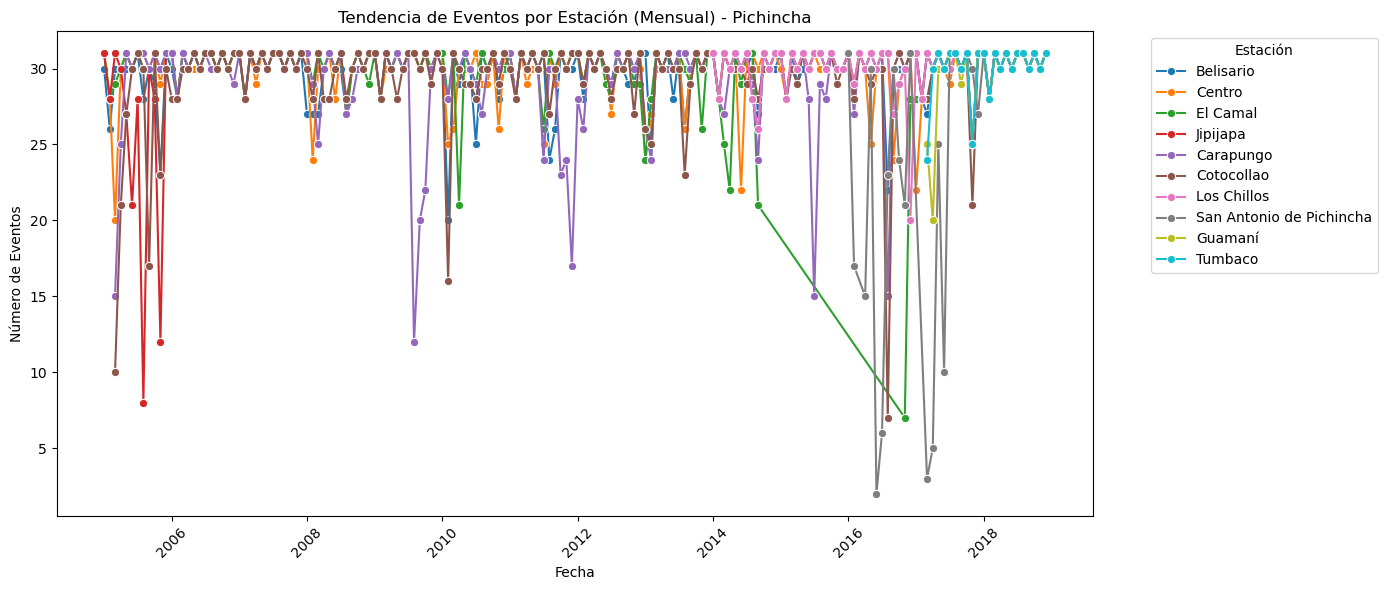

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.lineplot(data=tendencia_estacion, x='ANIO_MES', y='EVENTOS', hue='ESTACION', marker='o')

plt.title('Tendencia de Eventos por Estación (Mensual) - Pichincha')
plt.xlabel('Fecha')
plt.ylabel('Número de Eventos')
plt.legend(title='Estación', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


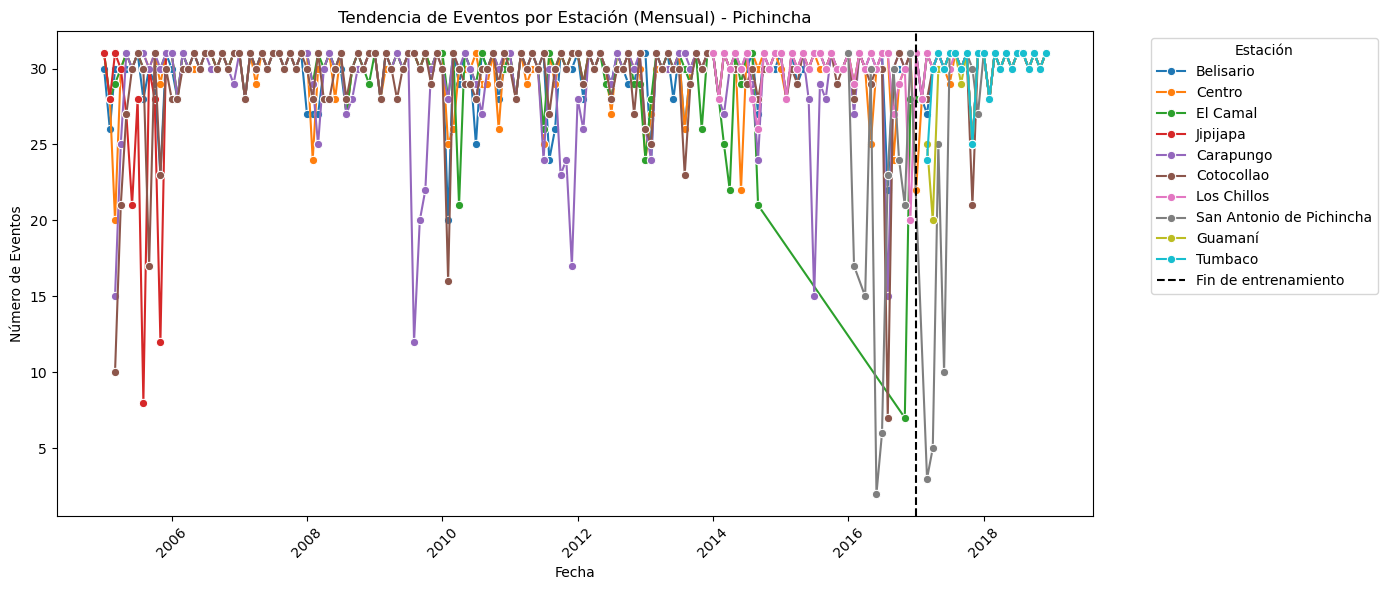

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear gráfico
plt.figure(figsize=(14, 6))
sns.lineplot(data=tendencia_estacion, x='ANIO_MES', y='EVENTOS', hue='ESTACION', marker='o')

# Línea vertical indicando el corte de entrenamiento
plt.axvline(pd.to_datetime('2016-12-31'), color='black', linestyle='--', label='Fin de entrenamiento')

# Estética
plt.title('Tendencia de Eventos por Estación (Mensual) - Pichincha')
plt.xlabel('Fecha')
plt.ylabel('Número de Eventos')
plt.legend(title='Estación', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 5. Modelado con ARIMA, SARIMA y SARIMAX
 
Se aplican modelos de series temporales ajustados a las características de cada estación. Se seleccionan órdenes óptimos (p,d,q) y (P,D,Q,s) mediante criterios AIC y BIC, y se evalúa el desempeño predictivo de cada modelo con métricas como MAE, RMSE y R².


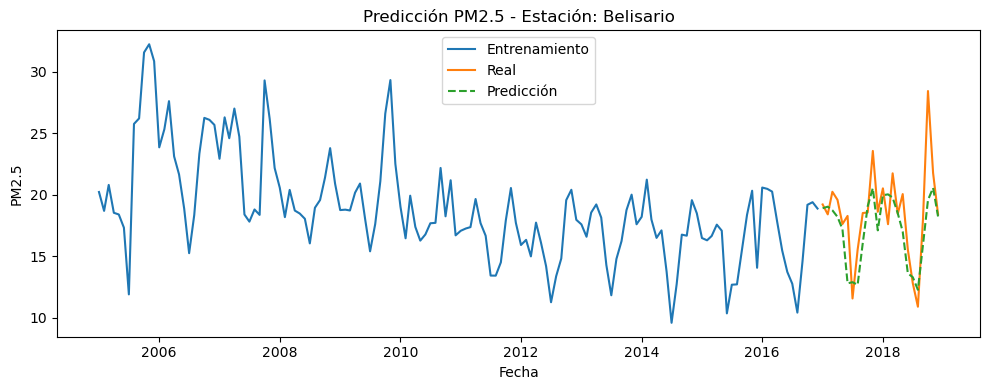

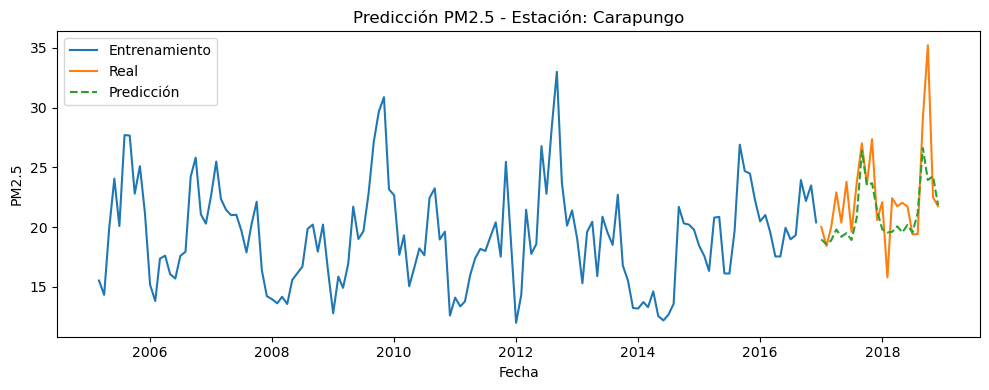

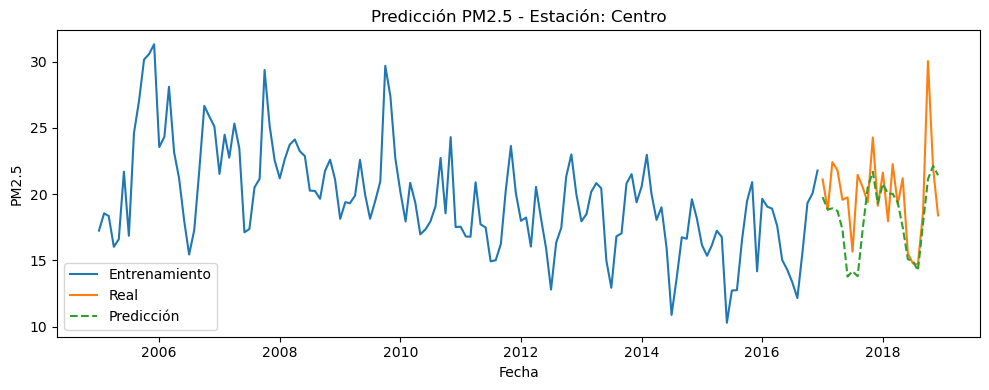

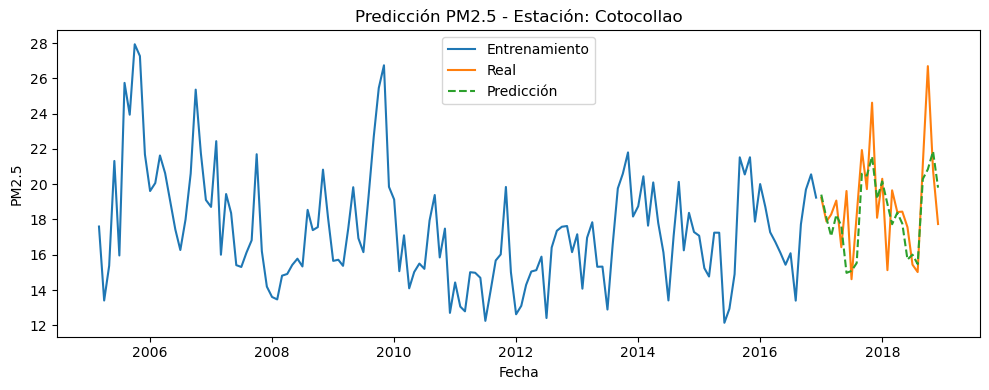

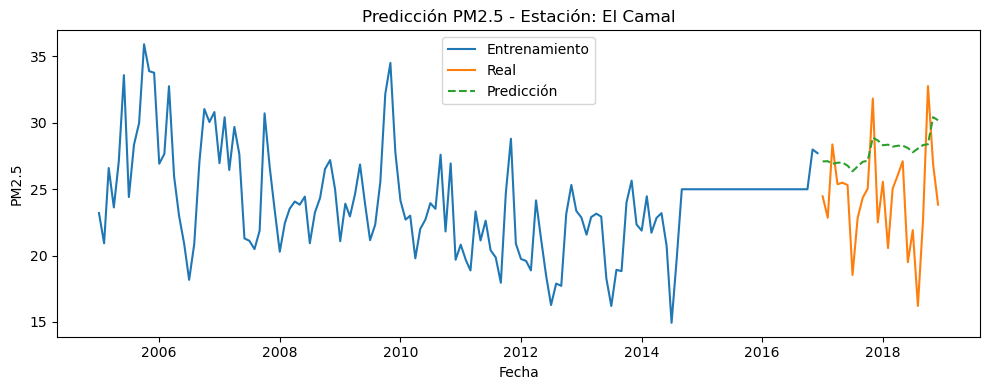

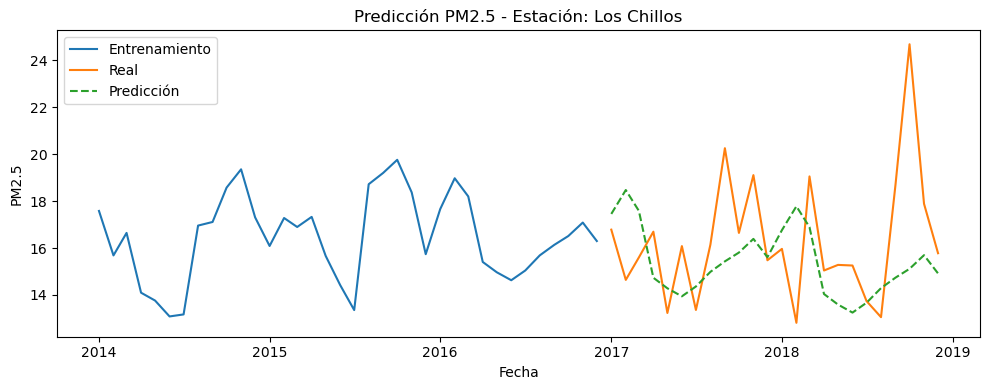

Resumen de desempeño del modelo por estación:
      Estacion   MAE  RMSE
3   Cotocollao  1.54  2.12
0    Belisario  1.90  2.68
5  Los Chillos  2.20  2.99
1    Carapungo  2.15  3.12
2       Centro  2.30  3.26
4     El Camal  4.24  5.02


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

# Ignorar warnings de convergencia que no afectan ejecución
warnings.filterwarnings("ignore")

# 1. Preparar datos
df['FECHA'] = pd.to_datetime(df['FECHA'])

# Filtrar Pichincha y quitar nulos
df_pichincha = df[(df['PROV'] == 'Pichincha') & (df['PM2.5'].notna())].copy()

# Crear columna mensual
df_pichincha['ANIO_MES'] = df_pichincha['FECHA'].dt.to_period('M').dt.to_timestamp()

# Agrupar por estación y mes
df_mensual = df_pichincha.groupby(['ESTACION', 'ANIO_MES'])['PM2.5'].mean().reset_index()

# Estaciones únicas
estaciones = df_mensual['ESTACION'].unique()

# Resultados
resultados = []

for estacion in estaciones:
    serie = df_mensual[df_mensual['ESTACION'] == estacion].set_index('ANIO_MES').sort_index()
    serie = serie.asfreq('MS')  # frecuencia mensual
    serie = serie['PM2.5'].ffill()  # reemplazo actualizado

    # Separar entrenamiento y prueba
    train = serie[serie.index <= '2016-12-01']
    test = serie[serie.index > '2016-12-01']

    # Requiere al menos 36 meses para entrenamiento
    if len(train) < 36 or len(test) == 0:
        continue

    try:
        model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12),
                        enforce_stationarity=False, enforce_invertibility=False)
        result = model.fit(disp=False, method='nm')  # método más estable

        # Predicción
        pred = result.predict(start=test.index[0], end=test.index[-1])

        # Métricas
        mae = mean_absolute_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))

        # Guardar resumen
        resultados.append({
            'Estacion': estacion,
            'MAE': round(mae, 2),
            'RMSE': round(rmse, 2)
        })

        # Gráfico
        plt.figure(figsize=(10, 4))
        plt.plot(train.index, train, label='Entrenamiento')
        plt.plot(test.index, test, label='Real')
        plt.plot(pred.index, pred, label='Predicción', linestyle='--')
        plt.title(f'Predicción PM2.5 - Estación: {estacion}')
        plt.xlabel('Fecha')
        plt.ylabel('PM2.5')
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error en estación {estacion}: {e}")

# Mostrar tabla resumen
resumen = pd.DataFrame(resultados).sort_values('RMSE')
print("Resumen de desempeño del modelo por estación:")
print(resumen)


Estación: Belisario
MAE  = 1.90
RMSE = 2.68
R²   = 0.452


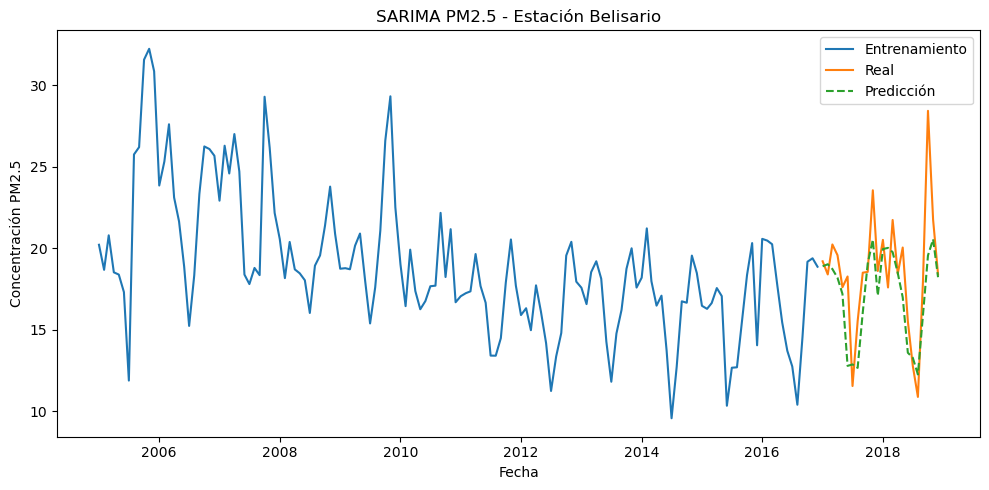

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Asegurarse que FECHA esté en datetime
df['FECHA'] = pd.to_datetime(df['FECHA'])

# Filtrar datos de Pichincha, estación Belisario, y sin nulos
df_belisario = df[(df['PROV'] == 'Pichincha') &
                  (df['ESTACION'] == 'Belisario') &
                  (df['PM2.5'].notna())].copy()

# Crear columna mensual
df_belisario['ANIO_MES'] = df_belisario['FECHA'].dt.to_period('M').dt.to_timestamp()

# Agrupar por mes: media mensual de PM2.5
serie = df_belisario.groupby('ANIO_MES')['PM2.5'].mean().asfreq('MS')
serie = serie.ffill()  # Rellenar faltantes

# Separar datos en entrenamiento y prueba
train = serie[serie.index <= '2016-12-01']
test = serie[serie.index > '2016-12-01']

# Entrenar modelo SARIMA
modelo = SARIMAX(train,
                 order=(1,1,1),
                 seasonal_order=(1,1,1,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False)

resultado = modelo.fit(disp=False, method='nm')  # Método robusto

# Predicción sobre el periodo de prueba
pred = resultado.predict(start=test.index[0], end=test.index[-1])

# Métricas de evaluación
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
r2 = r2_score(test, pred)

# Imprimir métricas
print(f"Estación: Belisario")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

# Gráfico de resultados
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Real')
plt.plot(pred.index, pred, label='Predicción', linestyle='--')
plt.title('SARIMA PM2.5 - Estación Belisario')
plt.xlabel('Fecha')
plt.ylabel('Concentración PM2.5')
plt.legend()
plt.tight_layout()
plt.show()



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=732.858, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=708.240, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=721.954, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=730.859, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=734.597, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=685.288, Time=0.17 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=680.869, Time=0.35 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=680.998, Time=0.19 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=681.887, Time=0.47 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=681.309, Time=0.32 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=696.239, Time=0.31 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=681.222, Time=0.44 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=669.387, Time=1.57 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   

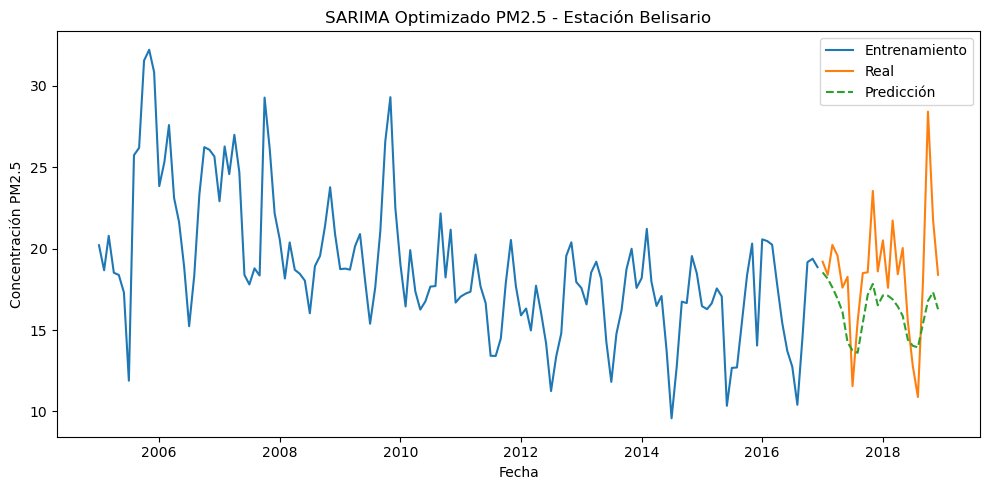

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pmdarima import auto_arima
import warnings

warnings.filterwarnings("ignore")

# 1. Preparar los datos
df['FECHA'] = pd.to_datetime(df['FECHA'])

# Filtrar Belisario y eliminar nulos
df_belisario = df[(df['PROV'] == 'Pichincha') &
                  (df['ESTACION'] == 'Belisario') &
                  (df['PM2.5'].notna())].copy()

# Crear columna mensual
df_belisario['ANIO_MES'] = df_belisario['FECHA'].dt.to_period('M').dt.to_timestamp()

# Agrupar por mes
serie = df_belisario.groupby('ANIO_MES')['PM2.5'].mean().asfreq('MS')
serie = serie.ffill()

# Dividir en entrenamiento y prueba
train = serie[serie.index <= '2016-12-01']
test = serie[serie.index > '2016-12-01']

# 2. Buscar mejores parámetros con auto_arima
modelo_opt = auto_arima(train,
                        seasonal=True,
                        m=12,
                        trace=True,
                        stepwise=True,
                        suppress_warnings=True)

print(modelo_opt.summary())

# 3. Entrenar modelo SARIMAX con los parámetros óptimos
order = modelo_opt.order
seasonal_order = modelo_opt.seasonal_order

modelo = SARIMAX(train,
                 order=order,
                 seasonal_order=seasonal_order,
                 enforce_stationarity=False,
                 enforce_invertibility=False)

resultado = modelo.fit(disp=False)

# 4. Predecir
pred = resultado.predict(start=test.index[0], end=test.index[-1])

# 5. Métricas
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
r2 = r2_score(test, pred)

# 6. Imprimir resultados
print(f"\nResultados para estación: Belisario")
print(f"Mejores parámetros SARIMA: {order} x {seasonal_order}")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

# 7. Graficar
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Real')
plt.plot(pred.index, pred, label='Predicción', linestyle='--')
plt.title('SARIMA Optimizado PM2.5 - Estación Belisario')
plt.xlabel('Fecha')
plt.ylabel('Concentración PM2.5')
plt.legend()
plt.tight_layout()
plt.show()


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=681.040, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=622.847, Time=0.12 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=627.032, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=682.636, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=654.101, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=620.185, Time=0.32 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=616.219, Time=0.60 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=614.404, Time=0.25 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=612.981, Time=0.18 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=614.466, Time=0.37 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=615.894, Time=0.73 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=652.227, Time=0.17 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=610.486, Time=0.23 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=655.267, Time=0.08 sec
 ARIMA(2,0,0)(1,1,1)[12] intercep

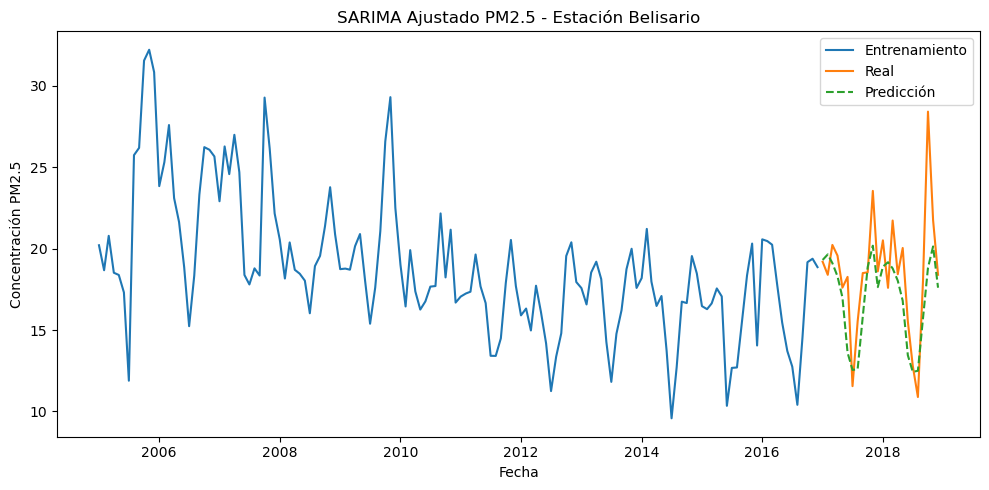

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pmdarima import auto_arima
import warnings

warnings.filterwarnings("ignore")

# 1. Preparar los datos
df['FECHA'] = pd.to_datetime(df['FECHA'])

df_belisario = df[(df['PROV'] == 'Pichincha') &
                  (df['ESTACION'] == 'Belisario') &
                  (df['PM2.5'].notna())].copy()

df_belisario['ANIO_MES'] = df_belisario['FECHA'].dt.to_period('M').dt.to_timestamp()

serie = df_belisario.groupby('ANIO_MES')['PM2.5'].mean().asfreq('MS')
serie = serie.ffill()

train = serie[serie.index <= '2016-12-01']
test = serie[serie.index > '2016-12-01']

# 2. Optimización semidirigida con D=1 y límites
modelo_opt = auto_arima(train,
                        seasonal=True,
                        m=12,
                        D=1,                # forzar diferenciación estacional
                        start_p=0, max_p=3,
                        start_q=0, max_q=3,
                        start_P=0, max_P=2,
                        start_Q=0, max_Q=2,
                        trace=True,
                        stepwise=True,
                        suppress_warnings=True)

print(modelo_opt.summary())

# 3. Entrenamiento con parámetros optimizados
order = modelo_opt.order
seasonal_order = modelo_opt.seasonal_order

modelo = SARIMAX(train,
                 order=order,
                 seasonal_order=seasonal_order,
                 enforce_stationarity=False,
                 enforce_invertibility=False)

resultado = modelo.fit(disp=False)

# 4. Predicción
pred = resultado.predict(start=test.index[0], end=test.index[-1])

# 5. Evaluación
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
r2 = r2_score(test, pred)

print(f"\nResultados para estación: Belisario")
print(f"Parámetros SARIMA ajustados: {order} x {seasonal_order}")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

# 6. Visualización
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Real')
plt.plot(pred.index, pred, label='Predicción', linestyle='--')
plt.title('SARIMA Ajustado PM2.5 - Estación Belisario')
plt.xlabel('Fecha')
plt.ylabel('Concentración PM2.5')
plt.legend()
plt.tight_layout()
plt.show()


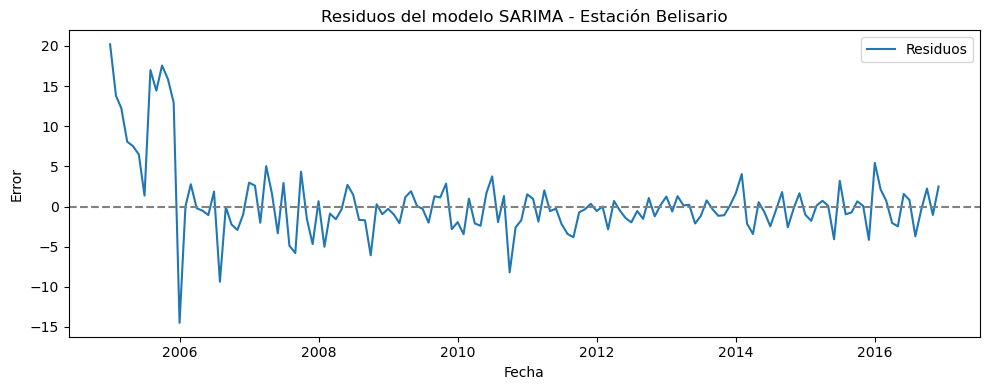

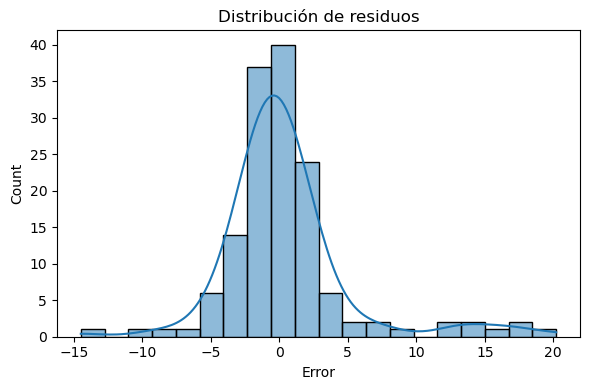

<Figure size 1000x400 with 0 Axes>

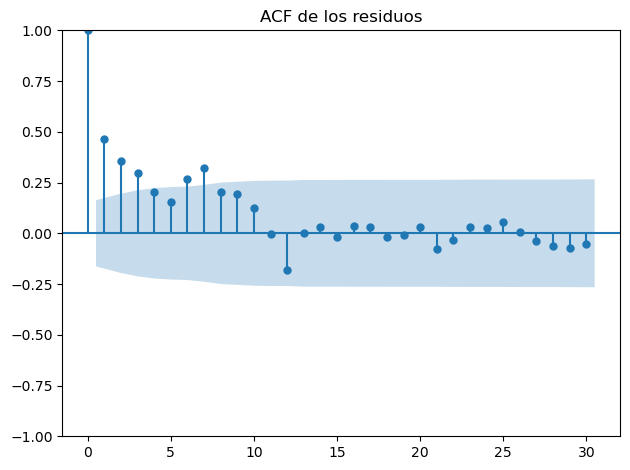


Prueba de Ljung-Box (lag=12):
      lb_stat     lb_pvalue
12  119.84344  6.640727e-20


In [123]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns

# 1. Obtener residuos del modelo ajustado
residuales = resultado.resid

# 2. Gráfico de residuos
plt.figure(figsize=(10, 4))
plt.plot(residuales, label='Residuos')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residuos del modelo SARIMA - Estación Belisario')
plt.xlabel('Fecha')
plt.ylabel('Error')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Histograma de distribución de residuos
plt.figure(figsize=(6, 4))
sns.histplot(residuales, bins=20, kde=True)
plt.title('Distribución de residuos')
plt.xlabel('Error')
plt.tight_layout()
plt.show()

# 4. Autocorrelación de los residuos
plt.figure(figsize=(10, 4))
plot_acf(residuales.dropna(), lags=30)
plt.title('ACF de los residuos')
plt.tight_layout()
plt.show()

# 5. (Opcional) Prueba de Ljung-Box para ruido blanco
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box = acorr_ljungbox(residuales.dropna(), lags=[12], return_df=True)
print("\nPrueba de Ljung-Box (lag=12):")
print(ljung_box)


In [125]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# 1. Preparar la serie mensual
df['FECHA'] = pd.to_datetime(df['FECHA'])
df_belisario = df[(df['PROV'] == 'Pichincha') &
                  (df['ESTACION'] == 'Belisario') &
                  (df['PM2.5'].notna())].copy()

df_belisario['ANIO_MES'] = df_belisario['FECHA'].dt.to_period('M').dt.to_timestamp()
serie = df_belisario.groupby('ANIO_MES')['PM2.5'].mean().asfreq('MS').ffill()

train = serie[serie.index <= '2016-12-01']
test = serie[serie.index > '2016-12-01']

# 2. Rango de parámetros
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 12

# 3. Combinaciones
param_combinations = list(itertools.product(p, d, q))
seasonal_combinations = list(itertools.product(P, D, Q))

mejores_modelos = []

# 4. Grid search
for param in param_combinations:
    for seasonal_param in seasonal_combinations:
        try:
            model = SARIMAX(train,
                            order=param,
                            seasonal_order=seasonal_param + (s,),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)

            # Residuales y prueba de Ljung-Box
            resid = results.resid
            pvalue_ljung = acorr_ljungbox(resid.dropna(), lags=[12], return_df=True)['lb_pvalue'].values[0]

            mejores_modelos.append({
                'order': param,
                'seasonal_order': seasonal_param + (s,),
                'AIC': results.aic,
                'Ljung_pvalue': pvalue_ljung
            })

        except:
            continue

# 5. Convertir resultados a DataFrame y mostrar los mejores
resultados_grid = pd.DataFrame(mejores_modelos)
resultados_grid_ordenado = resultados_grid.sort_values('AIC').reset_index(drop=True)

# Filtrar modelos que no tienen autocorrelación en residuos (p > 0.05)
modelos_validos = resultados_grid_ordenado[resultados_grid_ordenado['Ljung_pvalue'] > 0.05]

print("📉 Mejores modelos por AIC:")
print(resultados_grid_ordenado.head())

print("\n✅ Modelos sin autocorrelación en residuos (p > 0.05):")
print(modelos_validos.head())


📉 Mejores modelos por AIC:
       order seasonal_order         AIC  Ljung_pvalue
0  (1, 1, 2)  (1, 1, 1, 12)  517.770427  5.145778e-08
1  (2, 1, 2)  (1, 1, 1, 12)  518.027898  2.577227e-05
2  (0, 1, 2)  (1, 1, 1, 12)  518.038435  8.579203e-05
3  (1, 2, 2)  (1, 1, 1, 12)  519.203095  1.782916e-23
4  (2, 2, 2)  (1, 1, 1, 12)  520.225926  1.145827e-21

✅ Modelos sin autocorrelación en residuos (p > 0.05):
         order seasonal_order         AIC  Ljung_pvalue
112  (0, 1, 2)  (0, 0, 1, 12)  608.923127      0.393851
115  (1, 0, 2)  (0, 0, 1, 12)  612.516977      0.431545
122  (1, 1, 0)  (1, 0, 0, 12)  620.285164      0.052313
128  (0, 1, 0)  (1, 0, 0, 12)  627.516246      0.084808
135  (0, 1, 1)  (0, 0, 1, 12)  632.354134      0.120651



📈 Modelo final para Belisario:
Parámetros: (0, 1, 2) x (0, 0, 1, 12)
MAE  = 2.81
RMSE = 3.78
R²   = -0.092


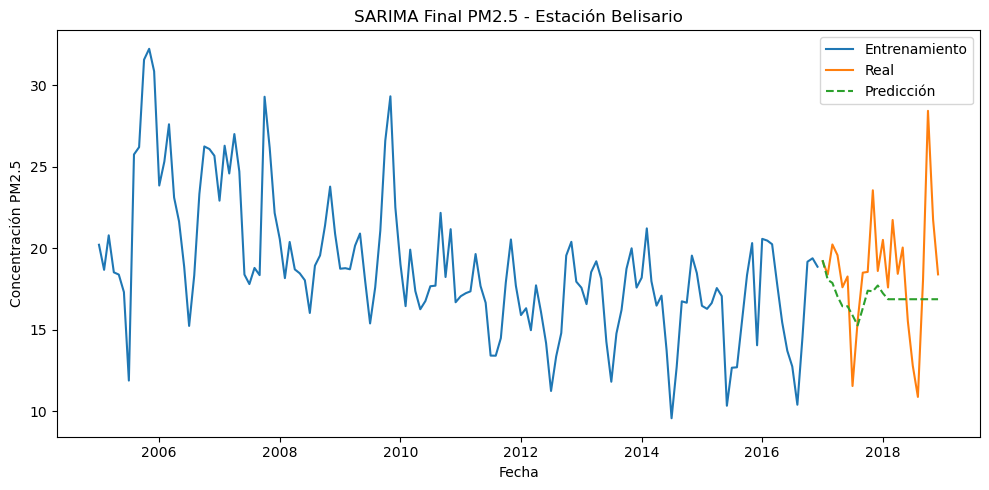

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore")

# Preparar la serie
df['FECHA'] = pd.to_datetime(df['FECHA'])
df_belisario = df[(df['PROV'] == 'Pichincha') &
                  (df['ESTACION'] == 'Belisario') &
                  (df['PM2.5'].notna())].copy()

df_belisario['ANIO_MES'] = df_belisario['FECHA'].dt.to_period('M').dt.to_timestamp()
serie = df_belisario.groupby('ANIO_MES')['PM2.5'].mean().asfreq('MS').ffill()

train = serie[serie.index <= '2016-12-01']
test = serie[serie.index > '2016-12-01']

# Modelo seleccionado por AIC + Ljung-Box
order = (0, 1, 2)
seasonal_order = (0, 0, 1, 12)

# Entrenar modelo
modelo = SARIMAX(train,
                 order=order,
                 seasonal_order=seasonal_order,
                 enforce_stationarity=False,
                 enforce_invertibility=False)

resultado = modelo.fit(disp=False)

# Predicción
pred = resultado.predict(start=test.index[0], end=test.index[-1])

# Métricas
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
r2 = r2_score(test, pred)

# Resultados
print(f"\n📈 Modelo final para Belisario:")
print(f"Parámetros: {order} x {seasonal_order}")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

# Gráfico
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Real')
plt.plot(pred.index, pred, label='Predicción', linestyle='--')
plt.title('SARIMA Final PM2.5 - Estación Belisario')
plt.xlabel('Fecha')
plt.ylabel('Concentración PM2.5')
plt.legend()
plt.tight_layout()
plt.show()



📈 Modelo SARIMA (2,0,1)x(1,1,1,12) - Belisario
MAE  = 2.82
RMSE = 3.46
R²   = 0.088


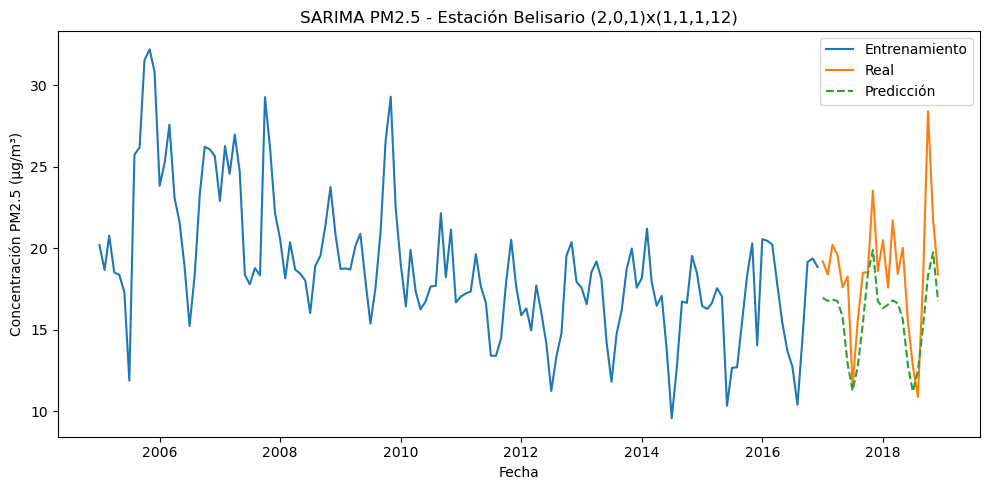

In [384]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore")

# Preparar la serie mensual
df['FECHA'] = pd.to_datetime(df['FECHA'])
df_belisario = df[(df['PROV'] == 'Pichincha') &
                  (df['ESTACION'] == 'Belisario') &
                  (df['PM2.5'].notna())].copy()

df_belisario['ANIO_MES'] = df_belisario['FECHA'].dt.to_period('M').dt.to_timestamp()
serie = df_belisario.groupby('ANIO_MES')['PM2.5'].mean().asfreq('MS').ffill()

train = serie[serie.index <= '2016-12-01']
test = serie[serie.index > '2016-12-01']

# Entrenar modelo SARIMA propuesto
order = (2, 0, 1)
seasonal_order = (1, 1, 1, 12)

modelo = SARIMAX(train,
                 order=order,
                 seasonal_order=seasonal_order,
                 enforce_stationarity=False,
                 enforce_invertibility=False)

resultado = modelo.fit(disp=False)

# Predicción
pred = resultado.predict(start=test.index[0], end=test.index[-1])

# Métricas
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
r2 = r2_score(test, pred)

# Resultados
print(f"\n Modelo SARIMA (2,0,1)x(1,1,1,12) - Belisario")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

# Visualización
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Real')
plt.plot(pred.index, pred, label='Predicción', linestyle='--')
plt.title('SARIMA PM2.5 - Estación Belisario (2,0,1)x(1,1,1,12)')
plt.xlabel('Fecha')
plt.ylabel('Concentración PM2.5 (µg/m³)')
plt.legend()
plt.tight_layout()
plt.show()



📈 Modelo SARIMA (1,1,1)x(1,1,1,12) - Belisario
MAE  = 2.99
RMSE = 3.67
R²   = -0.031


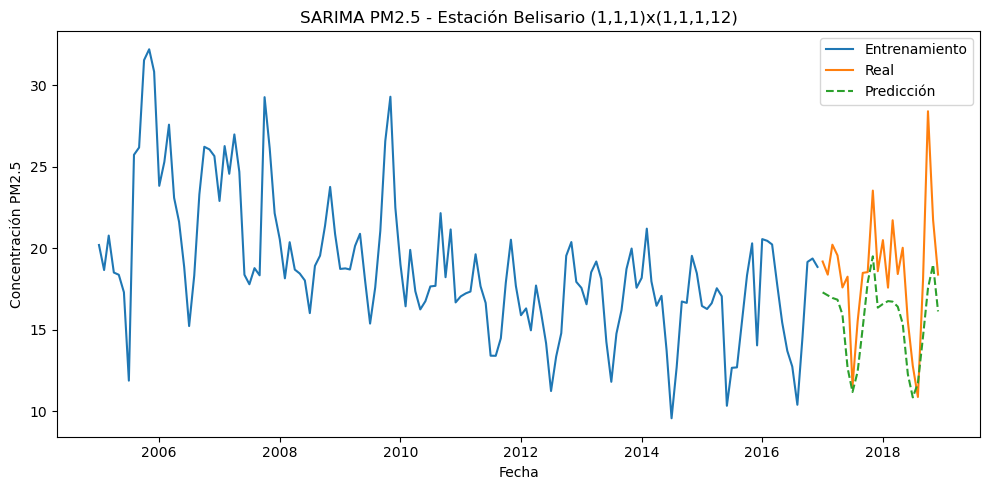

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore")

# Preparar la serie mensual
df['FECHA'] = pd.to_datetime(df['FECHA'])
df_belisario = df[(df['PROV'] == 'Pichincha') &
                  (df['ESTACION'] == 'Belisario') &
                  (df['PM2.5'].notna())].copy()

df_belisario['ANIO_MES'] = df_belisario['FECHA'].dt.to_period('M').dt.to_timestamp()
serie = df_belisario.groupby('ANIO_MES')['PM2.5'].mean().asfreq('MS').ffill()

train = serie[serie.index <= '2016-12-01']
test = serie[serie.index > '2016-12-01']

# Entrenar modelo SARIMA propuesto
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

modelo = SARIMAX(train,
                 order=order,
                 seasonal_order=seasonal_order,
                 enforce_stationarity=False,
                 enforce_invertibility=False)

resultado = modelo.fit(disp=False)

# Predicción
pred = resultado.predict(start=test.index[0], end=test.index[-1])

# Métricas
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
r2 = r2_score(test, pred)

# Resultados
print(f"\n Modelo SARIMA (1,1,1)x(1,1,1,12) - Belisario")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

# Visualización
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Real')
plt.plot(pred.index, pred, label='Predicción', linestyle='--')
plt.title('SARIMA PM2.5 - Estación Belisario (1,1,1)x(1,1,1,12)')
plt.xlabel('Fecha')
plt.ylabel('Concentración PM2.5')
plt.legend()
plt.tight_layout()
plt.show()


📈 Modelo ARIMA (1,1,1) - Belisario
MAE  = 3.03
RMSE = 3.94
R²   = -0.184


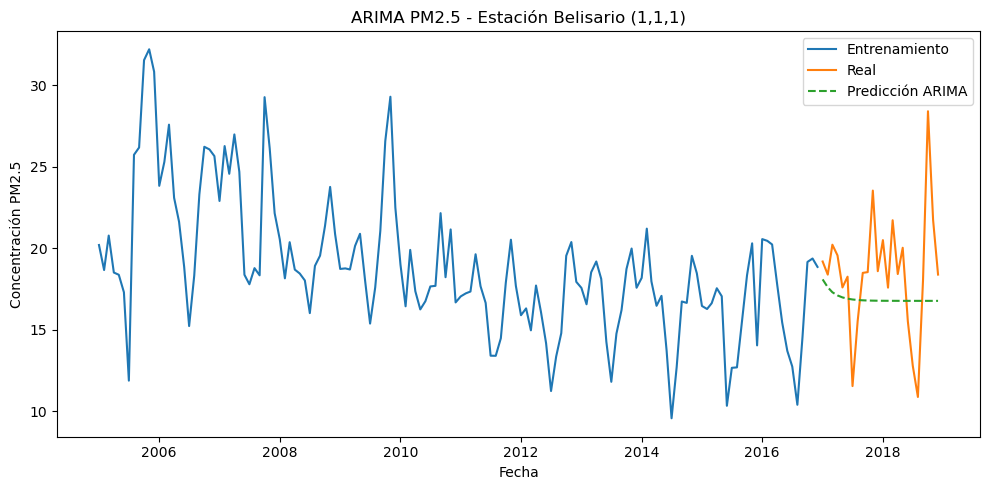

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore")

# Preparar la serie mensual
df['FECHA'] = pd.to_datetime(df['FECHA'])
df_belisario = df[(df['PROV'] == 'Pichincha') &
                  (df['ESTACION'] == 'Belisario') &
                  (df['PM2.5'].notna())].copy()

df_belisario['ANIO_MES'] = df_belisario['FECHA'].dt.to_period('M').dt.to_timestamp()
serie = df_belisario.groupby('ANIO_MES')['PM2.5'].mean().asfreq('MS').ffill()

# Separar entrenamiento y prueba
train = serie[serie.index <= '2016-12-01']
test = serie[serie.index > '2016-12-01']

# Entrenar modelo ARIMA (sin estacionalidad)
modelo_arima = ARIMA(train, order=(1, 1, 1))
resultado_arima = modelo_arima.fit()

# Predicción
pred_arima = resultado_arima.predict(start=test.index[0], end=test.index[-1])

# Métricas
mae = mean_absolute_error(test, pred_arima)
rmse = np.sqrt(mean_squared_error(test, pred_arima))
r2 = r2_score(test, pred_arima)

# Resultados
print(f"\n Modelo ARIMA (1,1,1) - Belisario")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

# Visualización
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Real')
plt.plot(pred_arima.index, pred_arima, label='Predicción ARIMA', linestyle='--')
plt.title('ARIMA PM2.5 - Estación Belisario (1,1,1)')
plt.xlabel('Fecha')
plt.ylabel('Concentración PM2.5')
plt.legend()
plt.tight_layout()
plt.show()


In [153]:
df['FECHA']

0       2005-01-01
1       2005-01-02
2       2005-01-03
3       2005-01-05
4       2005-01-06
           ...    
30978   2018-12-27
30979   2018-12-28
30980   2018-12-29
30981   2018-12-30
30982   2018-12-31
Name: FECHA, Length: 30983, dtype: datetime64[ns]

In [155]:
import pandas as pd
 
# Crear columna Año-Mes
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar provincia y estación
df_belisario = df[(df['PROV'] == 'Pichincha') & (df['ESTACION'] == 'Belisario')].copy()

# Agrupar y contar eventos por ANIO_MES
conteo_mensual = df_belisario.groupby('ANIO_MES').size().reset_index(name='NUM_EVENTOS')

# Ordenar por fecha (por si acaso)
conteo_mensual = conteo_mensual.sort_values(by='ANIO_MES')

# Mostrar la tabla
print(conteo_mensual)


    ANIO_MES  NUM_EVENTOS
0    2005-01           30
1    2005-02           26
2    2005-03           30
3    2005-04           30
4    2005-05           30
..       ...          ...
163  2018-08           31
164  2018-09           30
165  2018-10           31
166  2018-11           30
167  2018-12           31

[168 rows x 2 columns]


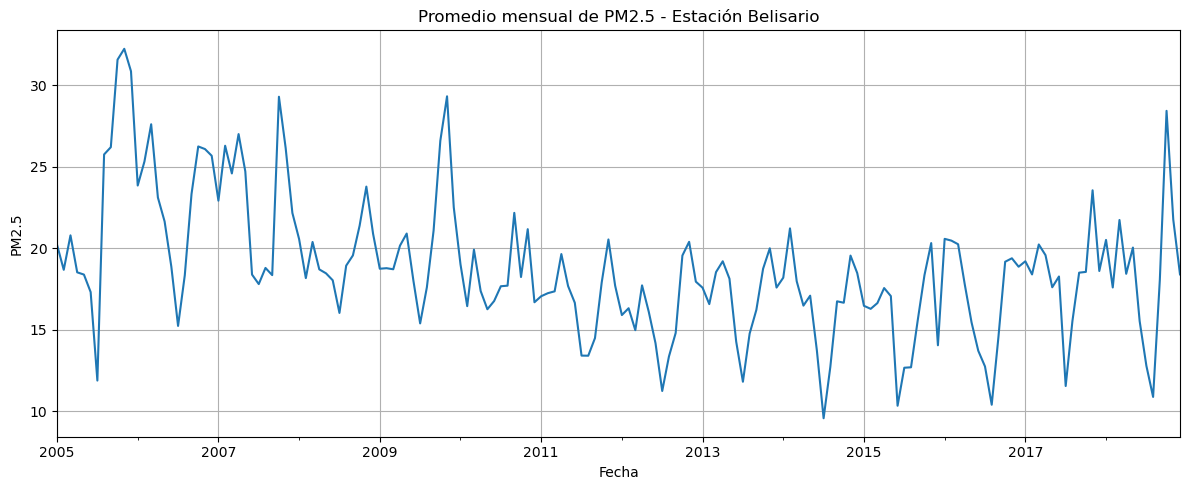

ADF Statistic: -1.9301107694391504
p-value: 0.3180312969274674
Critical Values:
  1%: -3.4729792729247793
  5%: -2.8802520918255534
  10%: -2.5767469641683105


In [159]:
# Paso 1: Importar librerías necesarias
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Paso 3: Filtrar datos de la estación Belisario en Pichincha
df_belisario = df[(df['PROV'] == 'Pichincha') & (df['ESTACION'] == 'Belisario') & (df['PM2.5'].notna())].copy()

# Paso 4: Agrupar por año-mes y calcular promedio mensual
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()

# Convertir índice a datetime para análisis de series de tiempo
serie_mensual.index = serie_mensual.index.to_timestamp()

# Visualizar la serie
serie_mensual.plot(figsize=(12, 5), title="Promedio mensual de PM2.5 - Estación Belisario")
plt.xlabel("Fecha")
plt.ylabel("PM2.5")
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 5: Prueba ADF (Augmented Dickey-Fuller)
resultado_adf = adfuller(serie_mensual.dropna())

# Paso 6: Mostrar resultados
print("ADF Statistic:", resultado_adf[0])
print("p-value:", resultado_adf[1])
print("Critical Values:")
for key, value in resultado_adf[4].items():
    print(f"  {key}: {value}")


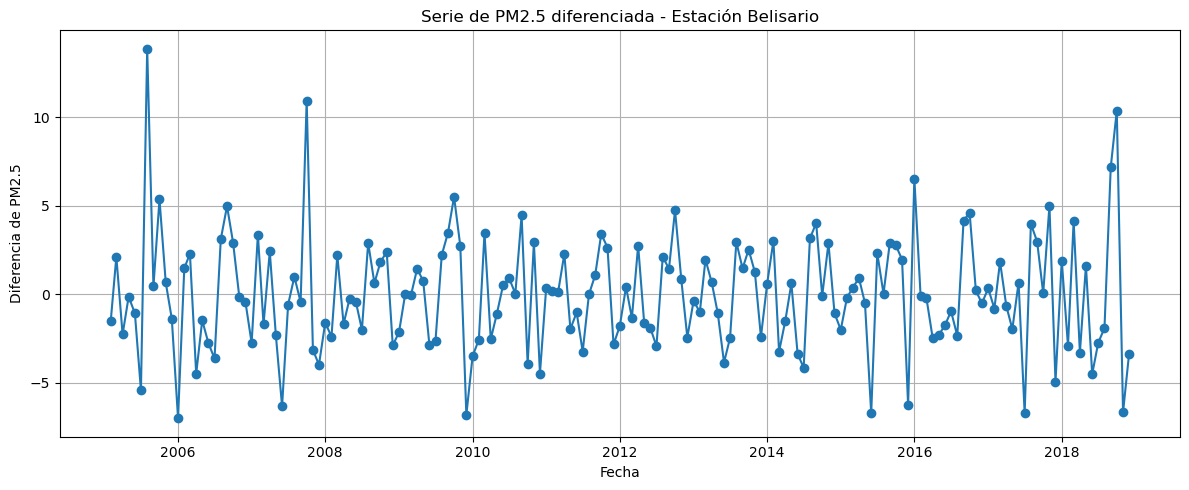

=== Resultado de la prueba ADF tras la diferenciación ===
ADF Statistic: -9.766761650002218
p-value: 7.314746927922632e-17
Critical Values:
  1%: -3.4729792729247793
  5%: -2.8802520918255534
  10%: -2.5767469641683105


In [162]:
# Paso 1: Importar librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Paso 3: Filtrar estación Belisario en Pichincha
df_belisario = df[
    (df['PROV'] == 'Pichincha') &
    (df['ESTACION'] == 'Belisario') &
    (df['PM2.5'].notna())
].copy()

# Paso 4: Agrupar por año-mes y calcular el promedio mensual
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Paso 5: Aplicar diferenciación de primer orden
serie_diff = serie_mensual.diff().dropna()

# Paso 6: Visualizar la serie diferenciada
plt.figure(figsize=(12, 5))
plt.plot(serie_diff, marker='o')
plt.title("Serie de PM2.5 diferenciada - Estación Belisario")
plt.xlabel("Fecha")
plt.ylabel("Diferencia de PM2.5")
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 7: Ejecutar prueba ADF sobre la serie diferenciada
resultado_adf_diff = adfuller(serie_diff)

# Paso 8: Mostrar resultados
print("=== Resultado de la prueba ADF tras la diferenciación ===")
print(f"ADF Statistic: {resultado_adf_diff[0]}")
print(f"p-value: {resultado_adf_diff[1]}")
print("Critical Values:")
for clave, valor in resultado_adf_diff[4].items():
    print(f"  {clave}: {valor}")


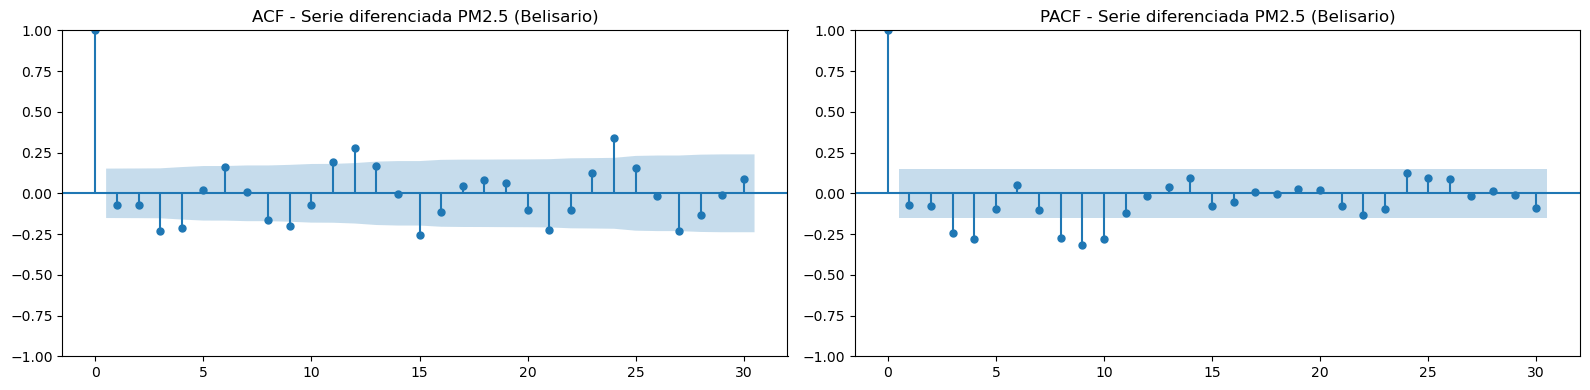

In [164]:
# Paso 1: Importar librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Paso 3: Filtrar estación Belisario
df_belisario = df[
    (df['PROV'] == 'Pichincha') &
    (df['ESTACION'] == 'Belisario') &
    (df['PM2.5'].notna())
].copy()

# Paso 4: Promedio mensual
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Paso 5: Aplicar diferenciación
serie_diff = serie_mensual.diff().dropna()

# Paso 6: Graficar ACF y PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(serie_diff, ax=axes[0], lags=30)
axes[0].set_title("ACF - Serie diferenciada PM2.5 (Belisario)")

plot_pacf(serie_diff, ax=axes[1], lags=30, method="ywm")
axes[1].set_title("PACF - Serie diferenciada PM2.5 (Belisario)")

plt.tight_layout()
plt.show()


                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                  168
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -420.091
Date:                Wed, 04 Jun 2025   AIC                            846.182
Time:                        17:15:50   BIC                            855.536
Sample:                    01-01-2005   HQIC                           849.978
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5964      0.067      8.903      0.000       0.465       0.728
ma.L1         -0.9536      0.038    -25.260      0.000      -1.028      -0.880
sigma2         8.9015      0.762     11.688      0.0

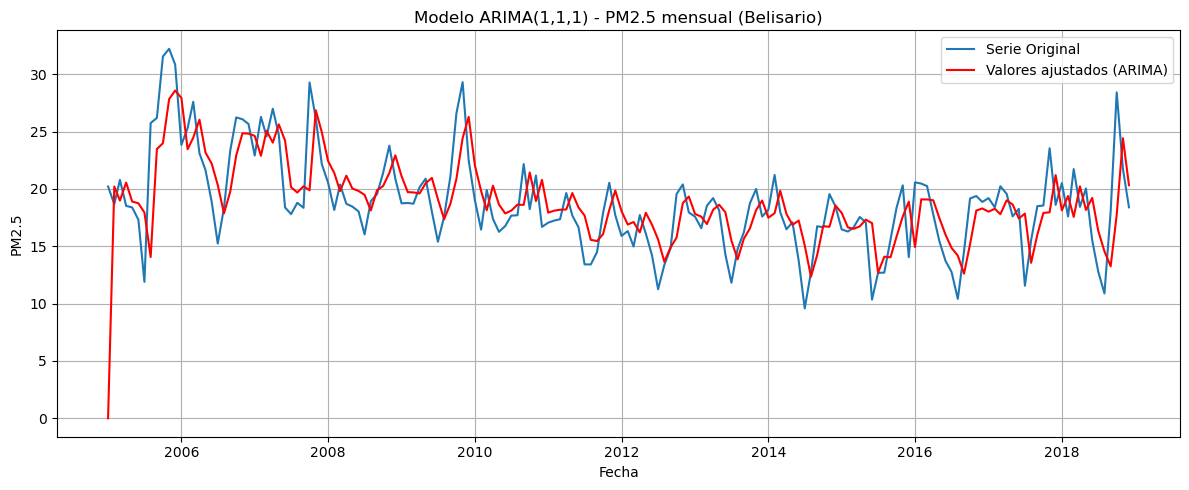


 Modelo final para Belisario:
Parámetros: (1, 1, 1) x (1, 1, 1, 12)
MAE  = 2.99
RMSE = 3.67
R²   = -0.031


In [180]:
# Paso 1: Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Paso 3: Filtrar Belisario y agrupar por mes
df_belisario = df[
    (df['PROV'] == 'Pichincha') &
    (df['ESTACION'] == 'Belisario') &
    (df['PM2.5'].notna())
].copy()

serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Paso 4: Entrenar modelo ARIMA(1,1,1)
modelo_arima = ARIMA(serie_mensual, order=(1,1,1))
modelo_entrenado = modelo_arima.fit()

# Paso 5: Resumen del modelo
print(modelo_entrenado.summary())

# Paso 6: Visualizar ajuste y predicción in-sample
plt.figure(figsize=(12, 5))
plt.plot(serie_mensual, label='Serie Original')
plt.plot(modelo_entrenado.fittedvalues, color='red', label='Valores ajustados (ARIMA)')
plt.title("Modelo ARIMA(1,1,1) - PM2.5 mensual (Belisario)")
plt.xlabel("Fecha")
plt.ylabel("PM2.5")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Métricas
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
r2 = r2_score(test, pred)

# Resultados
print(f"\n Modelo final para Belisario:")
print(f"Parámetros: {order} x {seasonal_order}")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

In [362]:
!pip install XlsxWriter


   ---------------------------------------- 0.0/169.4 kB ? eta -:--:--
   ---- ---------------------------------- 20.5/169.4 kB 330.3 kB/s eta 0:00:01
   ------- ------------------------------- 30.7/169.4 kB 330.3 kB/s eta 0:00:01
   -------------- ------------------------ 61.4/169.4 kB 409.6 kB/s eta 0:00:01
   --------------------- ----------------- 92.2/169.4 kB 525.1 kB/s eta 0:00:01
   ---------------------- --------------- 102.4/169.4 kB 454.0 kB/s eta 0:00:01
   -------------------------------- ----- 143.4/169.4 kB 532.5 kB/s eta 0:00:01
   ------------------------------------ - 163.8/169.4 kB 517.2 kB/s eta 0:00:01
   -------------------------------------- 169.4/169.4 kB 510.2 kB/s eta 0:00:00


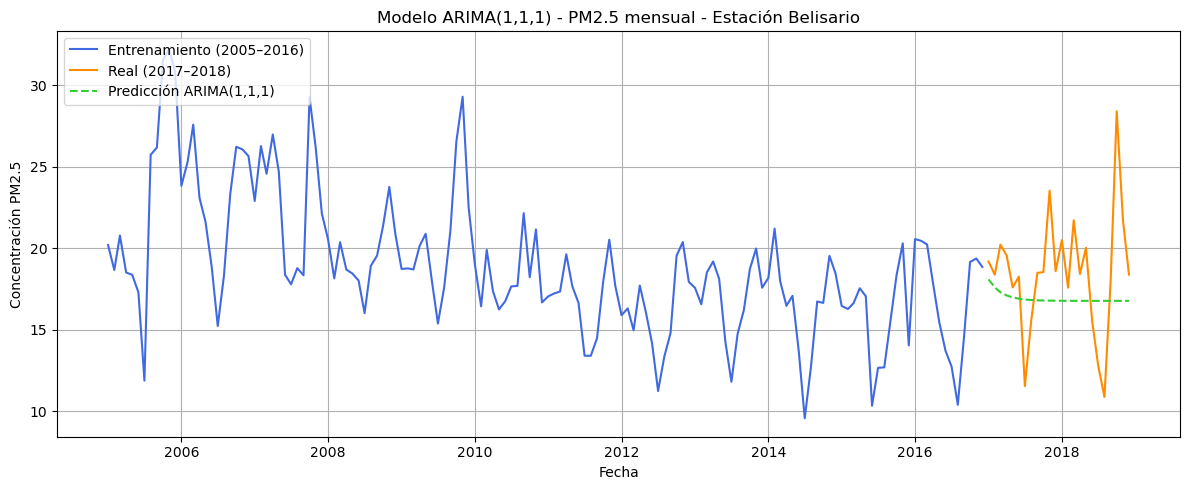

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -353.521
Date:                Sat, 14 Jun 2025   AIC                            713.042
Time:                        22:19:26   BIC                            721.930
Sample:                    01-01-2005   HQIC                           716.654
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6330      0.070      9.016      0.000       0.495       0.771
ma.L1         -0.9528      0.040    -23.769      0.000      -1.031      -0.874
sigma2         8.1590      0.789     10.335      0.0

In [380]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar estación Belisario
df_belisario = df[
    (df['PROV'] == 'Pichincha') &
    (df['ESTACION'] == 'Belisario') &
    (df['PM2.5'].notna())
].copy()

# Serie mensual
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar entrenamiento y prueba
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']
serie_test = serie_mensual[serie_mensual.index > '2016-12-01']

# Ajustar modelo ARIMA
modelo = ARIMA(serie_entrenamiento, order=(1,1,1))
modelo_entrenado = modelo.fit()
predicciones = modelo_entrenado.forecast(steps=len(serie_test))
predicciones.index = serie_test.index

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(serie_entrenamiento, label='Entrenamiento (2005–2016)', color='royalblue')
plt.plot(serie_test, label='Real (2017–2018)', color='darkorange')
plt.plot(predicciones, label='Predicción ARIMA(1,1,1)', color='limegreen', linestyle='--')

# Etiquetas y leyenda
plt.title("Modelo ARIMA(1,1,1) - PM2.5 mensual - Estación Belisario")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2.5")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 5: Resumen del modelo
print(modelo_entrenado.summary())

# Métricas
mae = mean_absolute_error(serie_test, predicciones)
rmse = np.sqrt(mean_squared_error(serie_test, predicciones))
r2 = r2_score(serie_test, predicciones)

# Resultados
print("\nModelo final para Belisario:")
print("Parámetros: (1, 1, 1)")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")


import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment
from openpyxl.utils import get_column_letter

# --- 1. Separar entrenamiento y prueba ---
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']
serie_test = serie_mensual[serie_mensual.index > '2016-12-01']

# --- 2. Predicción fuera de muestra ---
inicio = serie_test.index[0]
fin = serie_test.index[-1]

y_pred = resultado.predict(start=inicio, end=fin)
y_test = serie_test

# --- 3. Calcular solo las métricas requeridas ---
aic = resultado.aic
bic = resultado.bic
hqic = resultado.hqic
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# --- 4. Crear tabla de métricas clave ---
df_metricas = pd.DataFrame({
    "Parámetro": ['AIC', 'BIC', 'HQIC', 'MAE', 'RMSE', 'R²'],
    "Valor": [aic, bic, hqic, mae, rmse, r2]
})

# --- 5. Crear resumen textual interpretativo ---
resumen_texto = (
    f"El modelo ARIMA(1,1,1) ajustado para la estación Belisario presenta AIC = {aic:.2f}, "
    f"BIC = {bic:.2f}, HQIC = {hqic:.2f}. En evaluación post-2016, se obtuvo MAE = {mae:.2f}, "
    f"RMSE = {rmse:.2f}, y R² = {r2:.3f}, lo que sugiere "
    f"{'buena' if r2 > 0 else 'limitada'} capacidad predictiva.\n\n"
    " El resto de información técnica se integra en el repositorio del proceso."
)

# --- 6. Exportar a Excel con resumen en la primera fila ---
archivo = "resumen_modelo_belisario.xlsx"
df_metricas.to_excel(archivo, sheet_name="Resumen", startrow=2, index=False)

# --- 7. Formatear el resumen en celda fusionada ---
wb = load_workbook(archivo)
ws = wb["Resumen"]

# Fusionar celdas A1 hasta última columna
n_cols = ws.max_column
col_final = get_column_letter(n_cols)
ws.merge_cells(f"A1:{col_final}1")

# Insertar resumen en celda A1 con formato
cell = ws["A1"]
cell.value = resumen_texto
cell.font = Font(bold=True, size=12)
cell.alignment = Alignment(horizontal="left", vertical="top", wrap_text=True)

wb.save(archivo)



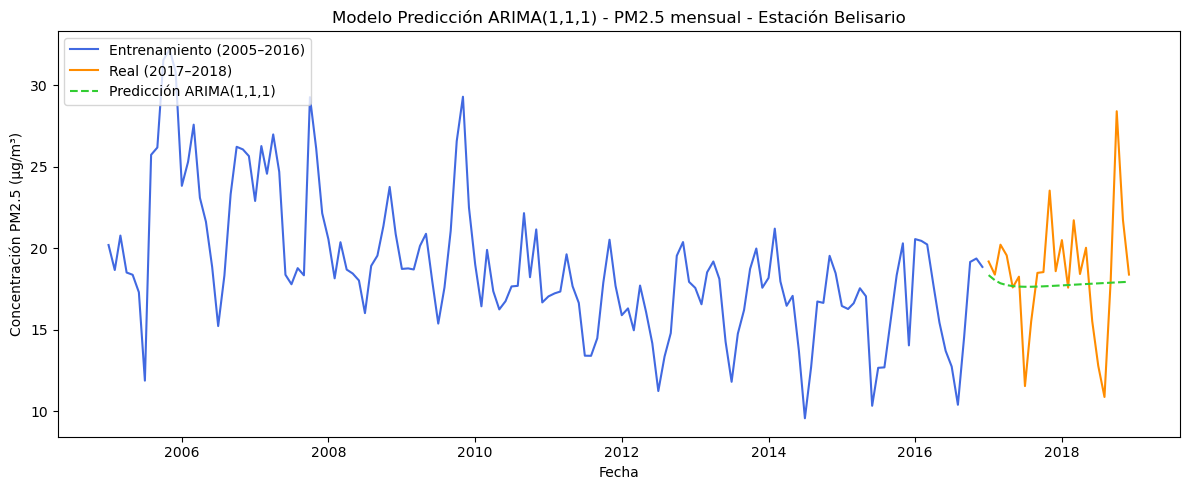

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                  144
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -355.421
Date:                Sun, 15 Jun 2025   AIC                            720.843
Time:                        01:11:02   BIC                            735.692
Sample:                    01-01-2005   HQIC                           726.877
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.0116      2.015      9.435      0.000      15.062      22.961
ar.L1          1.6198      0.103     15.768      0.000       1.418       1.821
ar.L2         -0.6261      0.091     -6.853      0.0

In [420]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar estación Belisario
df_belisario = df[
    (df['PROV'] == 'Pichincha') &
    (df['ESTACION'] == 'Belisario') &
    (df['PM2.5'].notna())
].copy()

# Serie mensual
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar entrenamiento y prueba
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']
serie_test = serie_mensual[serie_mensual.index > '2016-12-01']

# Ajustar modelo ARIMA
modelo = ARIMA(serie_entrenamiento, order=(2,0,1))
modelo_entrenado = modelo.fit()
predicciones = modelo_entrenado.forecast(steps=len(serie_test))
predicciones.index = serie_test.index

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(serie_entrenamiento, label='Entrenamiento (2005–2016)', color='royalblue')
plt.plot(serie_test, label='Real (2017–2018)', color='darkorange')
plt.plot(predicciones, label='Predicción ARIMA(1,1,1)', color='limegreen', linestyle='--')

# Etiquetas y leyenda
plt.title("Modelo Predicción ARIMA(1,1,1) - PM2.5 mensual - Estación Belisario")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2.5 (µg/m³)")
plt.legend(loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.show()

# Paso 5: Resumen del modelo
print(modelo_entrenado.summary())

# Métricas
mae = mean_absolute_error(serie_test, predicciones)
rmse = np.sqrt(mean_squared_error(serie_test, predicciones))
r2 = r2_score(serie_test, predicciones)

# Resultados
print("\nModelo final para Belisario:")
print("Parámetros: (2, 0, 1)")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

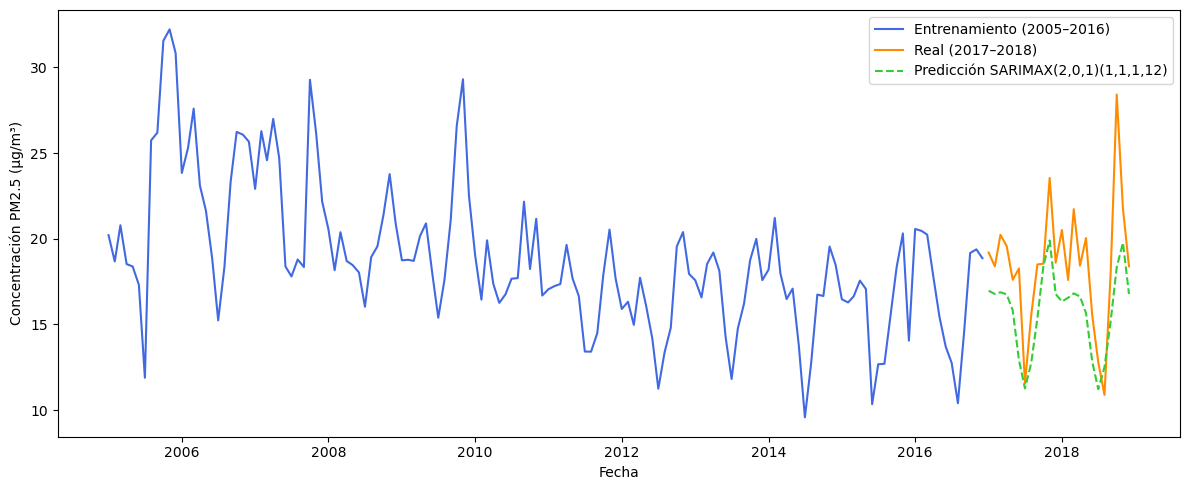

                                     SARIMAX Results                                      
Dep. Variable:                              PM2.5   No. Observations:                  144
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -256.399
Date:                            Sun, 15 Jun 2025   AIC                            524.799
Time:                                    01:48:46   BIC                            541.423
Sample:                                01-01-2005   HQIC                           531.549
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3817      0.106     13.092      0.000       1.175       1.589
ar.L2         -0.3939      0.103   

In [426]:
## Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar datos para Belisario
df_belisario = df[
    (df['PROV'] == 'Pichincha') &
    (df['ESTACION'] == 'Belisario') &
    (df['PM2.5'].notna())
].copy()

# Agrupar por mes
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar en entrenamiento y prueba
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']
serie_test = serie_mensual[serie_mensual.index > '2016-12-01']

# Entrenar modelo SARIMAX
modelo_sarimax = SARIMAX(serie_entrenamiento,
                         order=(2, 0, 1),
                         seasonal_order=(1, 1, 1, 12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)

resultado_sarimax = modelo_sarimax.fit(disp=False)

# Predecir
predicciones = resultado_sarimax.forecast(steps=len(serie_test))
predicciones.index = serie_test.index

# Graficar resultados
plt.figure(figsize=(12, 5))
plt.plot(serie_entrenamiento, label='Entrenamiento (2005–2016)', color='royalblue')
plt.plot(serie_test, label='Real (2017–2018)', color='darkorange')
plt.plot(predicciones, label='Predicción SARIMAX(2,0,1)(1,1,1,12)', color='limegreen', linestyle='--')
#plt.title("Modelo SARIMAX(2,0,1)(1,1,1,12) - PM2.5 mensual - Estación Belisario")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2.5 (µg/m³)")
plt.legend(loc='upper right')
plt.grid(False)
plt.tight_layout()
plt.show()

# Mostrar resumen del modelo
print(resultado_sarimax.summary())

# Calcular métricas
mae = mean_absolute_error(serie_test, predicciones)
rmse = np.sqrt(mean_squared_error(serie_test, predicciones))
r2 = r2_score(serie_test, predicciones)

# Imprimir resultados
print("\nModelo SARIMAX final para Belisario:")
print("Parámetros: (2, 0, 1) x (1, 1, 1, 12)")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")


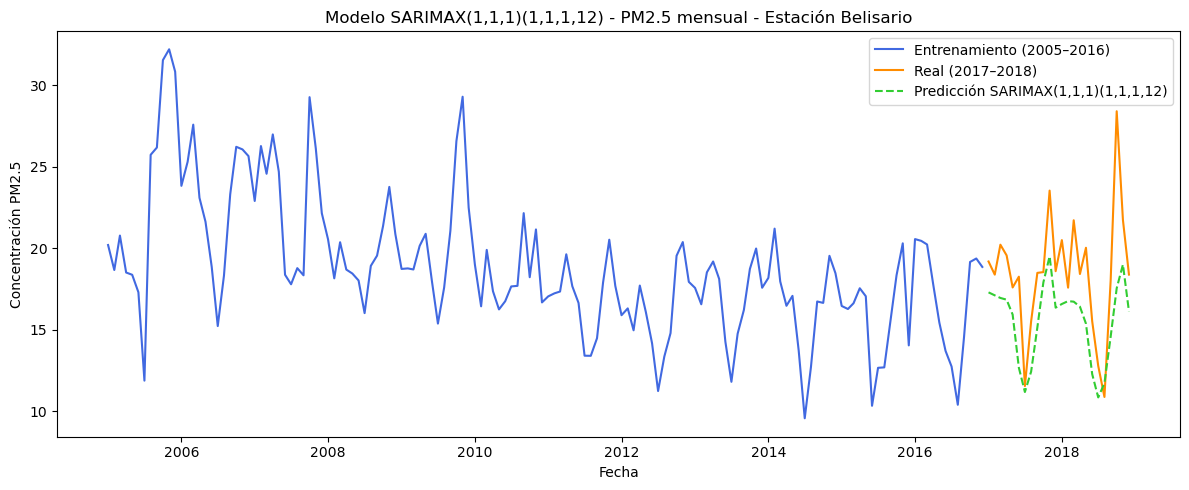

                                     SARIMAX Results                                      
Dep. Variable:                              PM2.5   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -256.416
Date:                            Sun, 15 Jun 2025   AIC                            522.832
Time:                                    01:52:19   BIC                            536.643
Sample:                                01-01-2005   HQIC                           528.439
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3774      0.121      3.106      0.002       0.139       0.616
ma.L1         -0.9147      0.068   

In [430]:
## Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar datos para Belisario
df_belisario = df[
    (df['PROV'] == 'Pichincha') &
    (df['ESTACION'] == 'Belisario') &
    (df['PM2.5'].notna())
].copy()

# Agrupar por mes
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar en entrenamiento y prueba
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']
serie_test = serie_mensual[serie_mensual.index > '2016-12-01']

# Entrenar modelo SARIMAX
modelo_sarimax = SARIMAX(serie_entrenamiento,
                         order=(1, 1, 1),
                         seasonal_order=(1, 1, 1, 12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)

resultado_sarimax = modelo_sarimax.fit(disp=False)

# Predecir
predicciones = resultado_sarimax.forecast(steps=len(serie_test))
predicciones.index = serie_test.index

# Graficar resultados
plt.figure(figsize=(12, 5))
plt.plot(serie_entrenamiento, label='Entrenamiento (2005–2016)', color='royalblue')
plt.plot(serie_test, label='Real (2017–2018)', color='darkorange')
plt.plot(predicciones, label='Predicción SARIMAX(1,1,1)(1,1,1,12)', color='limegreen', linestyle='--')
plt.title("Modelo SARIMAX(1,1,1)(1,1,1,12) - PM2.5 mensual - Estación Belisario")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2.5")
plt.legend(loc='upper right')
plt.grid(False)
plt.tight_layout()
plt.show()

# Mostrar resumen del modelo
print(resultado_sarimax.summary())

# Calcular métricas
mae = mean_absolute_error(serie_test, predicciones)
rmse = np.sqrt(mean_squared_error(serie_test, predicciones))
r2 = r2_score(serie_test, predicciones)

# Imprimir resultados
print("\nModelo SARIMAX final para Belisario:")
print("Parámetros: (1, 1, 1) x (1, 1, 1, 12)")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")


In [400]:
## import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar la estación Belisario
df_belisario = df[
    (df['PROV'] == 'Pichincha') &
    (df['ESTACION'] == 'Belisario') &
    (df['PM2.5'].notna())
].copy()

# Agrupar por mes
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar entrenamiento (hasta dic 2016)
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']

# Entrenar modelo SARIMAX(2,0,1)(1,1,1,12)
modelo_sarimax = SARIMAX(serie_entrenamiento,
                         order=(2, 0, 1),
                         seasonal_order=(1, 1, 1, 12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)

modelo_entrenado = modelo_sarimax.fit()

# Hacer predicción para 12 meses de 2023
pred = modelo_entrenado.get_forecast(steps=12)
pred_df = pred.summary_frame()

# Formatear índices de fecha
pred_df.index = pd.date_range(start='2017-01-31', periods=12, freq='M')

# Renombrar columnas para coincidir con el formato de tu tabla
pred_df = pred_df[['mean', 'mean_ci_lower', 'mean_ci_upper']]
pred_df.columns = ['Predicción', 'Límite Inferior', 'Límite Superior']

# Mostrar resultados
print(pred_df.round(6))


            Predicción  Límite Inferior  Límite Superior
2017-01-31   16.968925        13.113754        20.824097
2017-02-28   16.774489        12.622078        20.926901
2017-03-31   16.876583        12.679653        21.073512
2017-04-30   16.755402        12.552929        20.957875
2017-05-31   15.826957        11.625173        20.028740
2017-06-30   12.917390         8.717251        17.117529
2017-07-31   11.266522         7.068113        15.464932
2017-08-31   12.745251         8.548493        16.942009
2017-09-30   15.363081        11.167821        19.558342
2017-10-31   18.417738        14.223702        22.611774
2017-11-30   19.902559        15.709249        24.095869
2017-12-31   16.774219        12.580979        20.967458


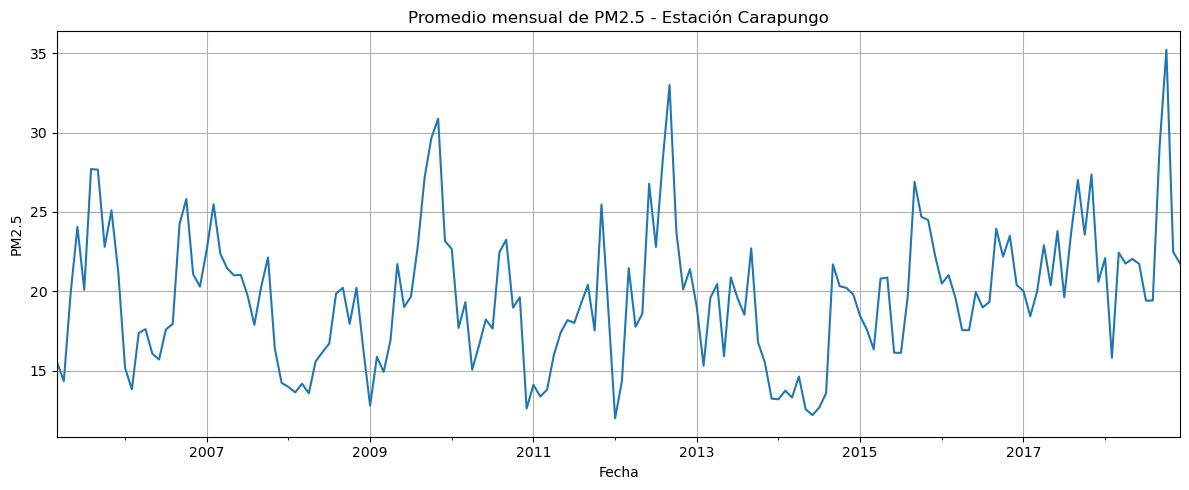

ADF Statistic: -3.603945530436497
p-value: 0.005686044139253659
Critical Values:
  1%: -3.4744158894942156
  5%: -2.880878382771059
  10%: -2.577081275821236


In [224]:
# Paso 1: Importar librerías necesarias
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Paso 3: Filtrar datos de la estación Belisario en Pichincha
df_belisario = df[(df['PROV'] == 'Pichincha') & (df['ESTACION'] == 'Carapungo') & (df['PM2.5'].notna())].copy()

# Paso 4: Agrupar por año-mes y calcular promedio mensual
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()

# Convertir índice a datetime para análisis de series de tiempo
serie_mensual.index = serie_mensual.index.to_timestamp()

# Visualizar la serie
serie_mensual.plot(figsize=(12, 5), title="Promedio mensual de PM2.5 - Estación Carapungo")
plt.xlabel("Fecha")
plt.ylabel("PM2.5")
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 5: Prueba ADF (Augmented Dickey-Fuller)
resultado_adf = adfuller(serie_mensual.dropna())

# Paso 6: Mostrar resultados
print("ADF Statistic:", resultado_adf[0])
print("p-value:", resultado_adf[1])
print("Critical Values:")
for key, value in resultado_adf[4].items():
    print(f"  {key}: {value}")

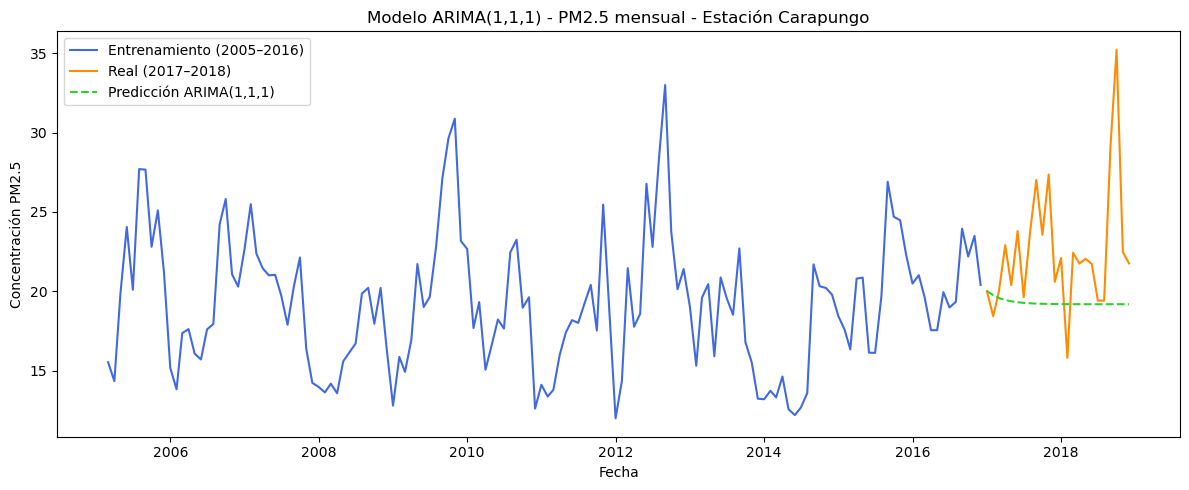

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                  142
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -359.697
Date:                Sun, 15 Jun 2025   AIC                            725.395
Time:                        00:26:39   BIC                            734.241
Sample:                    03-01-2005   HQIC                           728.989
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6841      0.075      9.179      0.000       0.538       0.830
ma.L1         -0.9998      3.441     -0.291      0.771      -7.744       5.744
sigma2         9.4030     32.542      0.289      0.7

In [404]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar estación Belisario
df_belisario = df[
    (df['PROV'] == 'Pichincha') &
    (df['ESTACION'] == 'Carapungo') &
    (df['PM2.5'].notna())
].copy()

# Serie mensual
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar entrenamiento y prueba
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']
serie_test = serie_mensual[serie_mensual.index > '2016-12-01']

# Ajustar modelo ARIMA
modelo = ARIMA(serie_entrenamiento, order=(1,1,1))
modelo_entrenado = modelo.fit()
predicciones = modelo_entrenado.forecast(steps=len(serie_test))
predicciones.index = serie_test.index

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(serie_entrenamiento, label='Entrenamiento (2005–2016)', color='royalblue')
plt.plot(serie_test, label='Real (2017–2018)', color='darkorange')
plt.plot(predicciones, label='Predicción ARIMA(1,1,1)', color='limegreen', linestyle='--')

# Etiquetas y leyenda
plt.title("Modelo ARIMA(1,1,1) - PM2.5 mensual - Estación Carapungo")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2.5")
plt.legend(loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.show()

# Paso 5: Resumen del modelo
print(modelo_entrenado.summary())

# Métricas
mae = mean_absolute_error(serie_test, predicciones)
rmse = np.sqrt(mean_squared_error(serie_test, predicciones))
r2 = r2_score(serie_test, predicciones)

# Resultados
print("\nModelo final para Carapungo:")
print("Parámetros: (1, 1, 1)")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

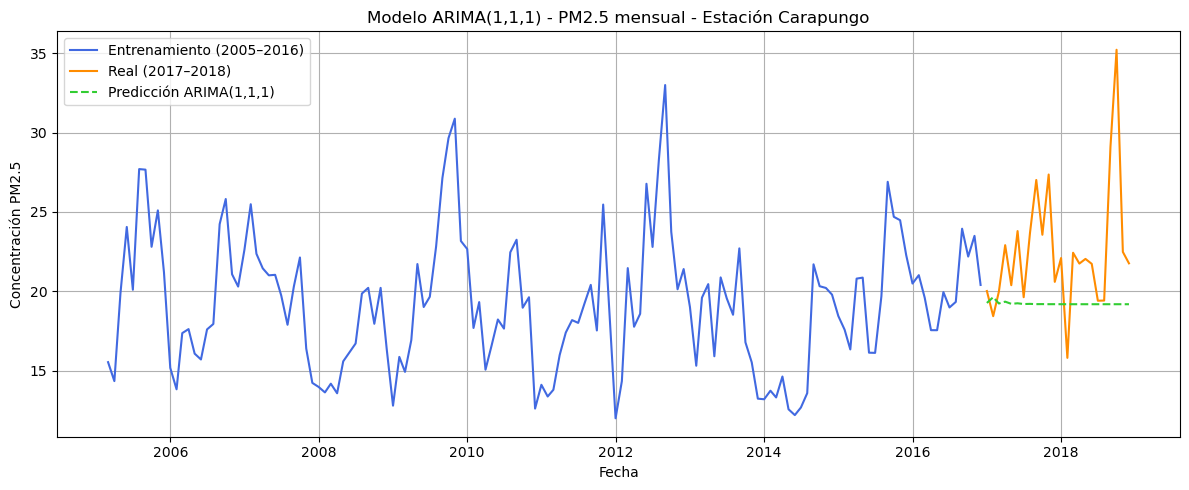

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                  142
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -358.461
Date:                Wed, 04 Jun 2025   AIC                            726.922
Time:                        18:46:08   BIC                            741.701
Sample:                    03-01-2005   HQIC                           732.927
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.1861      0.814     23.582      0.000      17.592      20.781
ar.L1          0.0412      0.265      0.156      0.876      -0.478       0.561
ar.L2          0.3616      0.195      1.855      0.0

In [218]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar estación Belisario
df_belisario = df[
    (df['PROV'] == 'Pichincha') &
    (df['ESTACION'] == 'Carapungo') &
    (df['PM2.5'].notna())
].copy()

# Serie mensual
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar entrenamiento y prueba
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']
serie_test = serie_mensual[serie_mensual.index > '2016-12-01']

# Ajustar modelo ARIMA
modelo = ARIMA(serie_entrenamiento, order=(2,0,1))
modelo_entrenado = modelo.fit()
predicciones = modelo_entrenado.forecast(steps=len(serie_test))
predicciones.index = serie_test.index

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(serie_entrenamiento, label='Entrenamiento (2005–2016)', color='royalblue')
plt.plot(serie_test, label='Real (2017–2018)', color='darkorange')
plt.plot(predicciones, label='Predicción ARIMA(1,1,1)', color='limegreen', linestyle='--')

# Etiquetas y leyenda
plt.title("Modelo ARIMA(1,1,1) - PM2.5 mensual - Estación Carapungo")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2.5")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 5: Resumen del modelo
print(modelo_entrenado.summary())

# Métricas
mae = mean_absolute_error(serie_test, predicciones)
rmse = np.sqrt(mean_squared_error(serie_test, predicciones))
r2 = r2_score(serie_test, predicciones)

# Resultados
print("\nModelo final para Carapungo:")
print("Parámetros: (2, 0, 1)")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

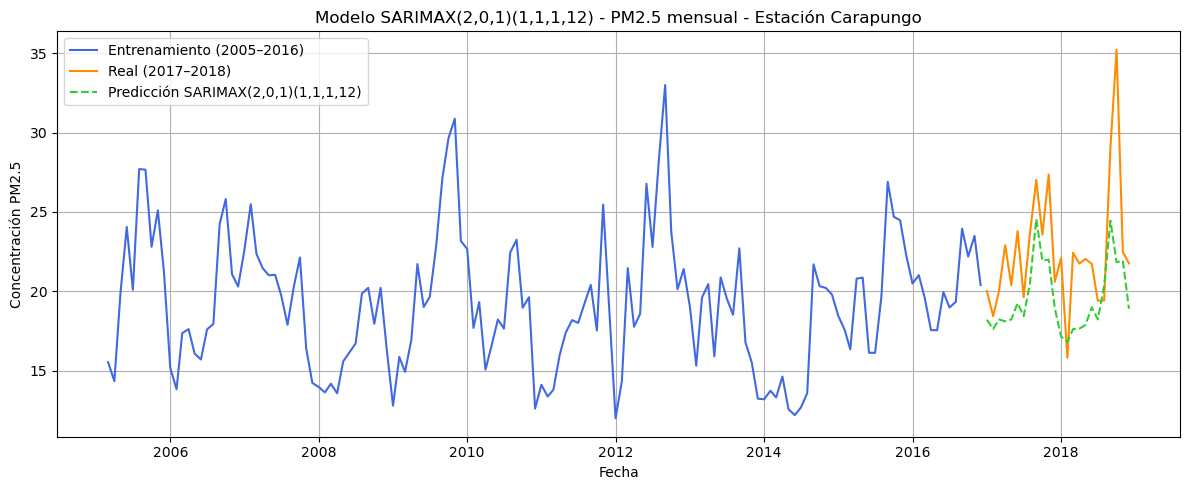

                                     SARIMAX Results                                      
Dep. Variable:                              PM2.5   No. Observations:                  142
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -281.961
Date:                            Wed, 04 Jun 2025   AIC                            575.921
Time:                                    18:46:59   BIC                            592.443
Sample:                                03-01-2005   HQIC                           582.628
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6534      0.872      0.750      0.453      -1.055       2.362
ar.L2          0.0790      0.615   

In [220]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar datos para Belisario
df_belisario = df[
    (df['PROV'] == 'Pichincha') &
    (df['ESTACION'] == 'Carapungo') &
    (df['PM2.5'].notna())
].copy()

# Agrupar por mes
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar en entrenamiento y prueba
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']
serie_test = serie_mensual[serie_mensual.index > '2016-12-01']

# Entrenar modelo SARIMAX
modelo_sarimax = SARIMAX(serie_entrenamiento,
                         order=(2, 0, 1),
                         seasonal_order=(1, 1, 1, 12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)

resultado_sarimax = modelo_sarimax.fit(disp=False)

# Predecir
predicciones = resultado_sarimax.forecast(steps=len(serie_test))
predicciones.index = serie_test.index

# Graficar resultados
plt.figure(figsize=(12, 5))
plt.plot(serie_entrenamiento, label='Entrenamiento (2005–2016)', color='royalblue')
plt.plot(serie_test, label='Real (2017–2018)', color='darkorange')
plt.plot(predicciones, label='Predicción SARIMAX(2,0,1)(1,1,1,12)', color='limegreen', linestyle='--')
plt.title("Modelo SARIMAX(2,0,1)(1,1,1,12) - PM2.5 mensual - Estación Carapungo")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2.5")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar resumen del modelo
print(resultado_sarimax.summary())

# Calcular métricas
mae = mean_absolute_error(serie_test, predicciones)
rmse = np.sqrt(mean_squared_error(serie_test, predicciones))
r2 = r2_score(serie_test, predicciones)

# Imprimir resultados
print("\nModelo SARIMAX final para Carapungo:")
print("Parámetros: (2, 0, 1) x (1, 1, 1, 12)")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")


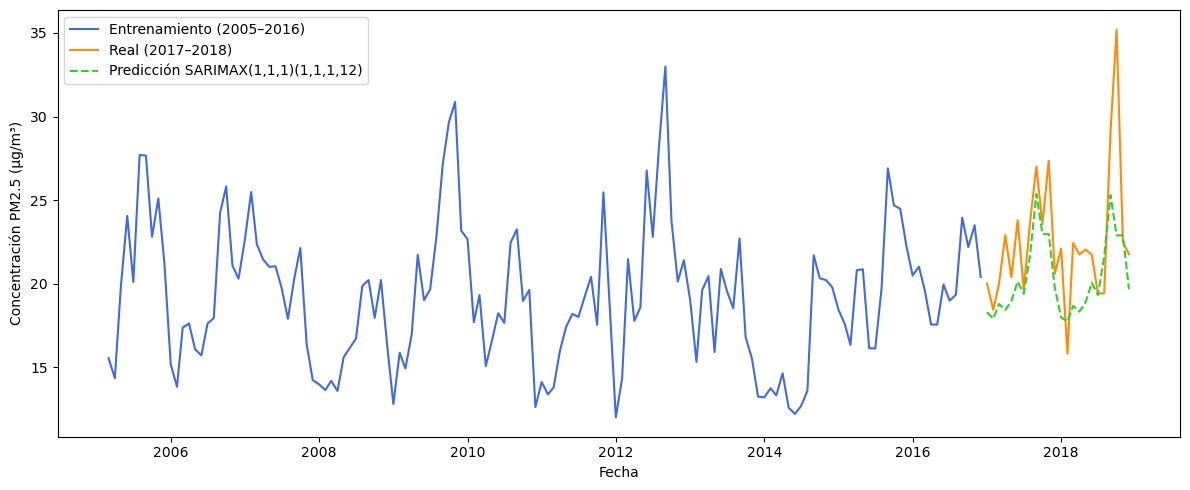

                                     SARIMAX Results                                      
Dep. Variable:                              PM2.5   No. Observations:                  142
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -283.314
Date:                            Sun, 15 Jun 2025   AIC                            576.629
Time:                                    01:54:11   BIC                            590.353
Sample:                                03-01-2005   HQIC                           582.200
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4049      0.210      1.929      0.054      -0.006       0.816
ma.L1         -0.7152      0.143   

In [432]:
## Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar datos para Belisario
df_belisario = df[
    (df['PROV'] == 'Pichincha') &
    (df['ESTACION'] == 'Carapungo') &
    (df['PM2.5'].notna())
].copy()

# Agrupar por mes
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar en entrenamiento y prueba
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']
serie_test = serie_mensual[serie_mensual.index > '2016-12-01']

# Entrenar modelo SARIMAX
modelo_sarimax = SARIMAX(serie_entrenamiento,
                         order=(1, 1, 1),
                         seasonal_order=(1, 1, 1, 12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)

resultado_sarimax = modelo_sarimax.fit(disp=False)

# Predecir
predicciones = resultado_sarimax.forecast(steps=len(serie_test))
predicciones.index = serie_test.index

# Graficar resultados
plt.figure(figsize=(12, 5))
plt.plot(serie_entrenamiento, label='Entrenamiento (2005–2016)', color='royalblue')
plt.plot(serie_test, label='Real (2017–2018)', color='darkorange')
plt.plot(predicciones, label='Predicción SARIMAX(1,1,1)(1,1,1,12)', color='limegreen', linestyle='--')
#plt.title("Modelo SARIMAX(1,1,1)(1,1,1,12) - PM2.5 mensual - Estación Carapungo")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2.5 (µg/m³)")
plt.legend(loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.show()

# Mostrar resumen del modelo
print(resultado_sarimax.summary())

# Calcular métricas
mae = mean_absolute_error(serie_test, predicciones)
rmse = np.sqrt(mean_squared_error(serie_test, predicciones))
r2 = r2_score(serie_test, predicciones)

# Imprimir resultados
print("\nModelo SARIMAX final para Carapungo:")
print("Parámetros: (1, 1, 1) x (1, 1, 1, 12)")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")


In [238]:
## import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar la estación Belisario
df_belisario = df[
    (df['PROV'] == 'Pichincha') &
    (df['ESTACION'] == 'Carapungo') &
    (df['PM2.5'].notna())
].copy()

# Agrupar por mes
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar entrenamiento (hasta dic 2016)
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']

# Entrenar modelo SARIMAX(1,1,1)(1,1,1,12)
modelo_sarimax = SARIMAX(serie_entrenamiento,
                         order=(1, 1, 1),
                         seasonal_order=(1, 1, 1, 12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)

modelo_entrenado = modelo_sarimax.fit()

# Hacer predicción para 12 meses de 2023
pred = modelo_entrenado.get_forecast(steps=12)
pred_df = pred.summary_frame()

# Formatear índices de fecha
pred_df.index = pd.date_range(start='2017-01-31', periods=12, freq='M')

# Renombrar columnas para coincidir con el formato de tu tabla
pred_df = pred_df[['mean', 'mean_ci_lower', 'mean_ci_upper']]
pred_df.columns = ['Predicción', 'Límite Inferior', 'Límite Superior']

# Mostrar resultados
print(pred_df.round(6))

            Predicción  Límite Inferior  Límite Superior
2017-01-31   18.291742        12.976825        23.606658
2017-02-28   17.898282        11.441973        24.354591
2017-03-31   18.780233        11.661978        25.898488
2017-04-30   18.416302        10.798962        26.033642
2017-05-31   18.954207        10.899172        27.009241
2017-06-30   20.133046        11.677681        28.588411
2017-07-31   19.391762        10.560375        28.223148
2017-08-31   21.693697        12.504141        30.883253
2017-09-30   25.368860        15.835561        34.902159
2017-10-31   22.963783        13.099096        32.828469
2017-11-30   22.963144        12.777998        33.148290
2017-12-31   19.736453         9.240687        30.232219


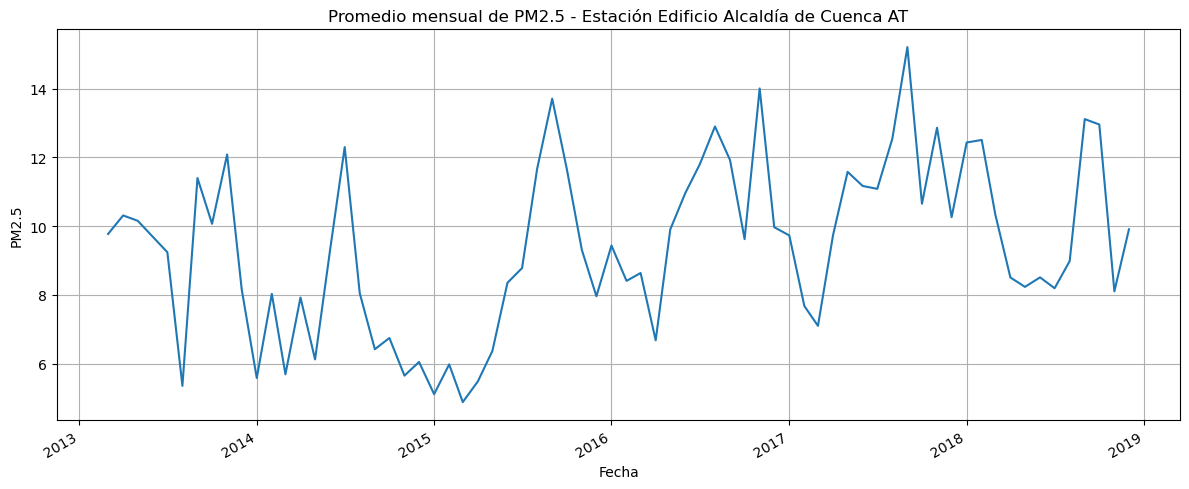

ADF Statistic: -4.167462463647095
p-value: 0.000747632990364846
Critical Values:
  1%: -3.530398990560757
  5%: -2.9050874099328317
  10%: -2.5900010121107266


In [228]:
# Paso 1: Importar librerías necesarias
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Paso 3: Filtrar datos de la estación Belisario en Pichincha
df_belisario = df[(df['PROV'] == 'Azuay') & (df['ESTACION'] == 'Edificio Alcaldía de Cuenca AT') & (df['PM2.5'].notna())].copy()

# Paso 4: Agrupar por año-mes y calcular promedio mensual
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()

# Convertir índice a datetime para análisis de series de tiempo
serie_mensual.index = serie_mensual.index.to_timestamp()

# Visualizar la serie
serie_mensual.plot(figsize=(12, 5), title="Promedio mensual de PM2.5 - Estación Edificio Alcaldía de Cuenca AT")
plt.xlabel("Fecha")
plt.ylabel("PM2.5")
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 5: Prueba ADF (Augmented Dickey-Fuller)
resultado_adf = adfuller(serie_mensual.dropna())

# Paso 6: Mostrar resultados
print("ADF Statistic:", resultado_adf[0])
print("p-value:", resultado_adf[1])
print("Critical Values:")
for key, value in resultado_adf[4].items():
    print(f"  {key}: {value}")

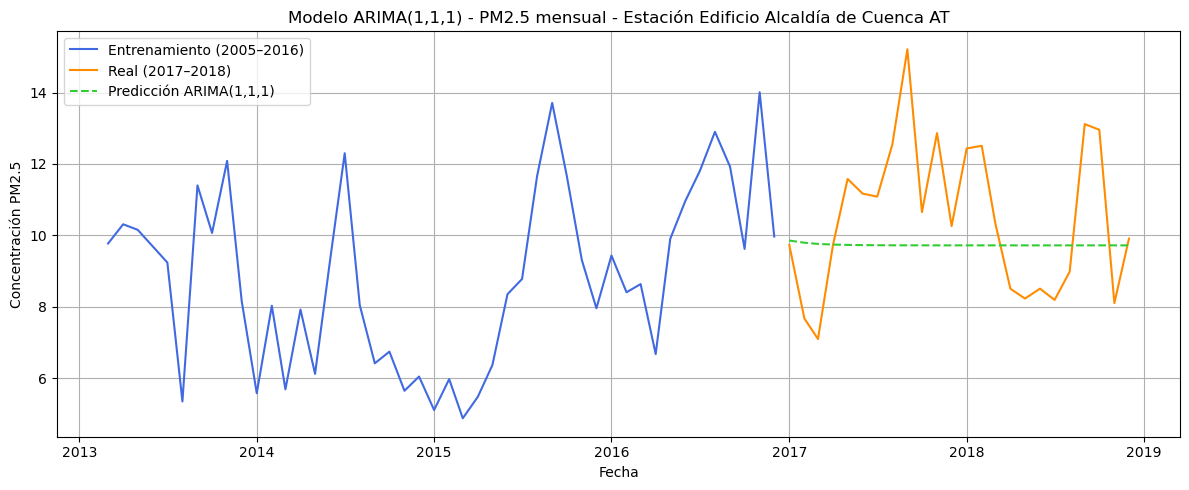

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                   45
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -95.447
Date:                Wed, 04 Jun 2025   AIC                            196.893
Time:                        23:09:27   BIC                            202.246
Sample:                             0   HQIC                           198.878
                                 - 45                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5462      0.156      3.508      0.000       0.241       0.851
ma.L1         -0.9322      0.115     -8.119      0.000      -1.157      -0.707
sigma2         4.3873      1.124      3.902      0.0

In [230]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar estación Belisario
df_belisario = df[
    (df['PROV'] == 'Azuay') &
    (df['ESTACION'] == 'Edificio Alcaldía de Cuenca AT') &
    (df['PM2.5'].notna())
].copy()

# Serie mensual
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar entrenamiento y prueba
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']
serie_test = serie_mensual[serie_mensual.index > '2016-12-01']

# Ajustar modelo ARIMA
modelo = ARIMA(serie_entrenamiento, order=(1,1,1))
modelo_entrenado = modelo.fit()
predicciones = modelo_entrenado.forecast(steps=len(serie_test))
predicciones.index = serie_test.index

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(serie_entrenamiento, label='Entrenamiento (2005–2016)', color='royalblue')
plt.plot(serie_test, label='Real (2017–2018)', color='darkorange')
plt.plot(predicciones, label='Predicción ARIMA(1,1,1)', color='limegreen', linestyle='--')

# Etiquetas y leyenda
plt.title("Modelo ARIMA(1,1,1) - PM2.5 mensual - Estación Edificio Alcaldía de Cuenca AT")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2.5")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 5: Resumen del modelo
print(modelo_entrenado.summary())

# Métricas
mae = mean_absolute_error(serie_test, predicciones)
rmse = np.sqrt(mean_squared_error(serie_test, predicciones))
r2 = r2_score(serie_test, predicciones)

# Resultados
print("\nModelo final para Edificio Alcaldía de Cuenca AT:")
print("Parámetros: (1, 1, 1)")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

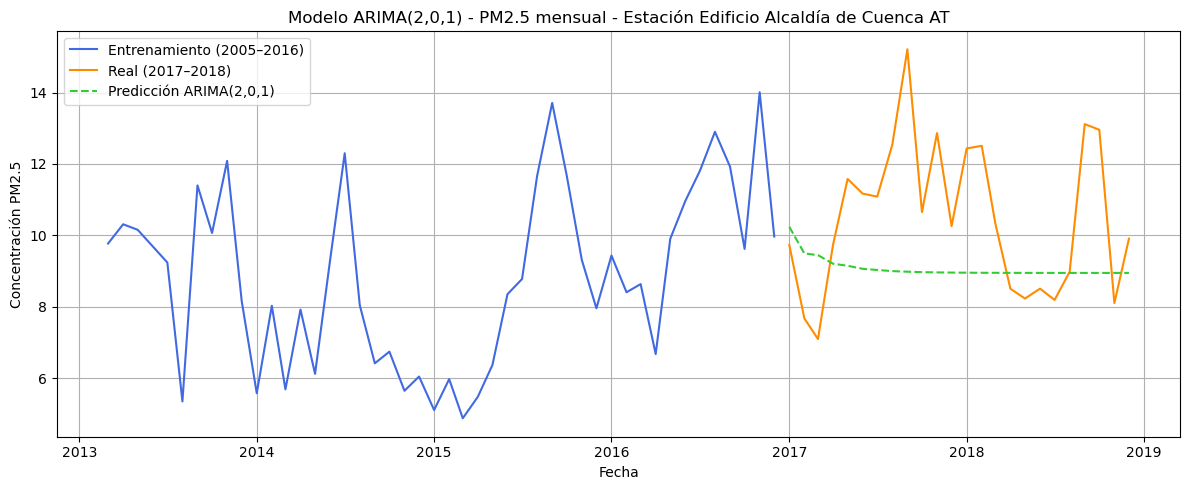

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                   45
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 -95.612
Date:                Wed, 04 Jun 2025   AIC                            201.225
Time:                        23:26:04   BIC                            210.258
Sample:                             0   HQIC                           204.592
                                 - 45                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9484      0.800     11.187      0.000       7.381      10.516
ar.L1          0.1770      1.027      0.172      0.863      -1.836       2.190
ar.L2          0.3109      0.573      0.543      0.5

In [252]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar estación Belisario
df_belisario = df[
    (df['PROV'] == 'Azuay') &
    (df['ESTACION'] == 'Edificio Alcaldía de Cuenca AT') &
    (df['PM2.5'].notna())
].copy()

# Serie mensual
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar entrenamiento y prueba
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']
serie_test = serie_mensual[serie_mensual.index > '2016-12-01']

# Ajustar modelo ARIMA
modelo = ARIMA(serie_entrenamiento, order=(2,0,1))
modelo_entrenado = modelo.fit()
predicciones = modelo_entrenado.forecast(steps=len(serie_test))
predicciones.index = serie_test.index

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(serie_entrenamiento, label='Entrenamiento (2005–2016)', color='royalblue')
plt.plot(serie_test, label='Real (2017–2018)', color='darkorange')
plt.plot(predicciones, label='Predicción ARIMA(2,0,1)', color='limegreen', linestyle='--')

# Etiquetas y leyenda
plt.title("Modelo ARIMA(2,0,1) - PM2.5 mensual - Estación Edificio Alcaldía de Cuenca AT")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2.5")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 5: Resumen del modelo
print(modelo_entrenado.summary())

# Métricas
mae = mean_absolute_error(serie_test, predicciones)
rmse = np.sqrt(mean_squared_error(serie_test, predicciones))
r2 = r2_score(serie_test, predicciones)

# Resultados
print("\nModelo final para Edificio Alcaldía de Cuenca AT:")
print("Parámetros: (2, 0, 1)")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

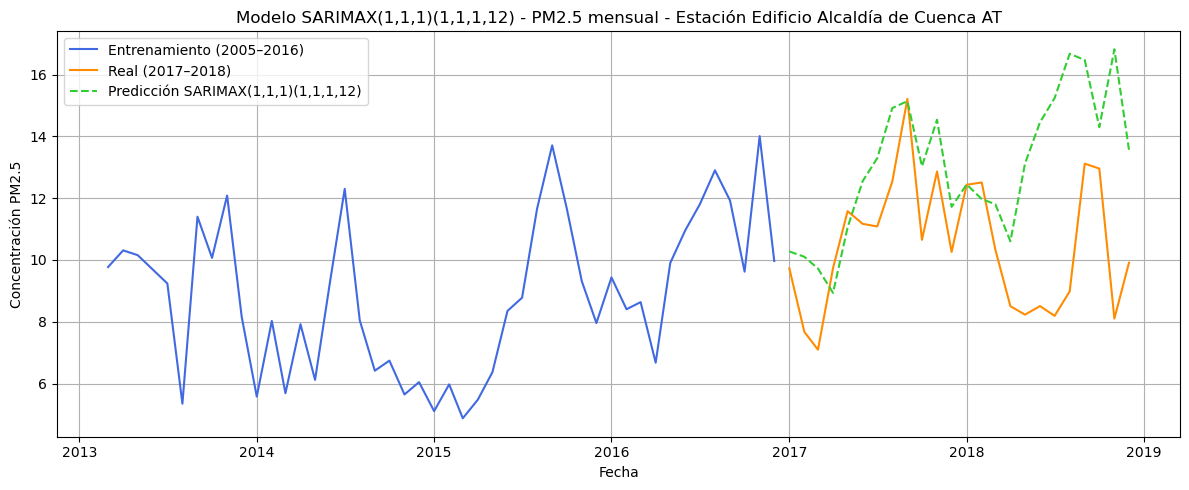

                                     SARIMAX Results                                      
Dep. Variable:                              PM2.5   No. Observations:                   45
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -42.669
Date:                            Wed, 04 Jun 2025   AIC                             95.337
Time:                                    23:18:28   BIC                             99.789
Sample:                                         0   HQIC                            95.951
                                             - 45                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1843      0.851      0.217      0.829      -1.484       1.853
ma.L1         -0.7526      0.590   

In [242]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar datos para Belisario
df_belisario = df[
    (df['PROV'] == 'Azuay') &
    (df['ESTACION'] == 'Edificio Alcaldía de Cuenca AT') &
    (df['PM2.5'].notna())
].copy()

# Agrupar por mes
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar en entrenamiento y prueba
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']
serie_test = serie_mensual[serie_mensual.index > '2016-12-01']

# Entrenar modelo SARIMAX
modelo_sarimax = SARIMAX(serie_entrenamiento,
                         order=(1, 1, 1),
                         seasonal_order=(1, 1, 1, 12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)

resultado_sarimax = modelo_sarimax.fit(disp=False)

# Predecir
predicciones = resultado_sarimax.forecast(steps=len(serie_test))
predicciones.index = serie_test.index

# Graficar resultados
plt.figure(figsize=(12, 5))
plt.plot(serie_entrenamiento, label='Entrenamiento (2005–2016)', color='royalblue')
plt.plot(serie_test, label='Real (2017–2018)', color='darkorange')
plt.plot(predicciones, label='Predicción SARIMAX(1,1,1)(1,1,1,12)', color='limegreen', linestyle='--')
plt.title("Modelo SARIMAX(1,1,1)(1,1,1,12) - PM2.5 mensual - Estación Edificio Alcaldía de Cuenca AT")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2.5")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar resumen del modelo
print(resultado_sarimax.summary())

# Calcular métricas
mae = mean_absolute_error(serie_test, predicciones)
rmse = np.sqrt(mean_squared_error(serie_test, predicciones))
r2 = r2_score(serie_test, predicciones)

# Imprimir resultados
print("\nModelo SARIMAX final para Edificio Alcaldía de Cuenca AT:")
print("Parámetros: (1, 1, 1) x (1, 1, 1, 12)")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")


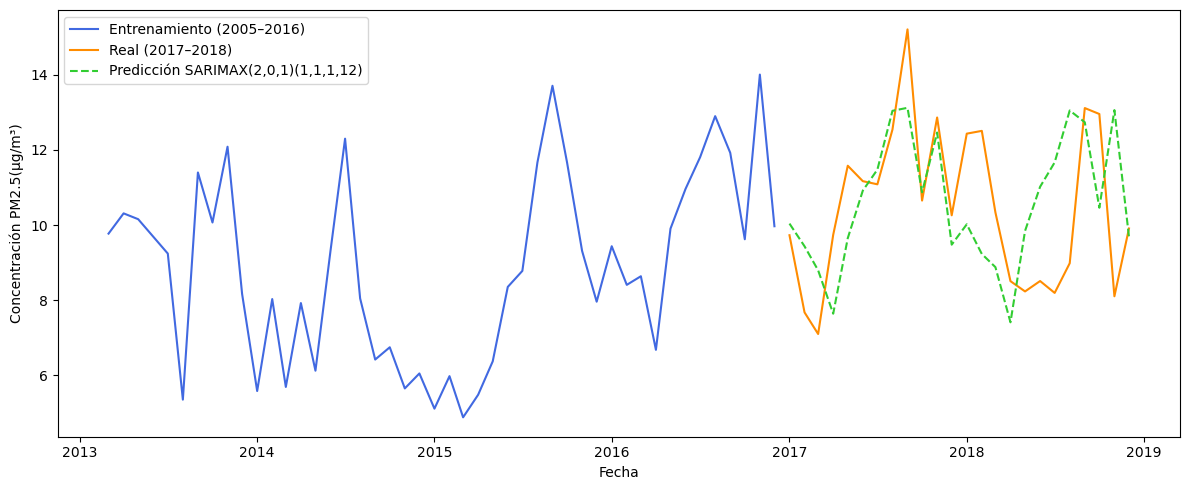

                                     SARIMAX Results                                      
Dep. Variable:                              PM2.5   No. Observations:                   45
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 12)   Log Likelihood                 -44.311
Date:                            Sun, 15 Jun 2025   AIC                            100.621
Time:                                    02:00:40   BIC                            106.288
Sample:                                         0   HQIC                           101.580
                                             - 45                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8455      1.359      0.622      0.534      -1.817       3.508
ar.L2         -0.0023      1.049   

In [434]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar datos para Belisario
df_belisario = df[
    (df['PROV'] == 'Azuay') &
    (df['ESTACION'] == 'Edificio Alcaldía de Cuenca AT') &
    (df['PM2.5'].notna())
].copy()

# Agrupar por mes
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar en entrenamiento y prueba
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']
serie_test = serie_mensual[serie_mensual.index > '2016-12-01']

# Entrenar modelo SARIMAX
modelo_sarimax = SARIMAX(serie_entrenamiento,
                         order=(2, 0, 1),
                         seasonal_order=(1, 1, 1, 12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)

resultado_sarimax = modelo_sarimax.fit(disp=False)

# Predecir
predicciones = resultado_sarimax.forecast(steps=len(serie_test))
predicciones.index = serie_test.index

# Graficar resultados
plt.figure(figsize=(12, 5))
plt.plot(serie_entrenamiento, label='Entrenamiento (2005–2016)', color='royalblue')
plt.plot(serie_test, label='Real (2017–2018)', color='darkorange')
plt.plot(predicciones, label='Predicción SARIMAX(2,0,1)(1,1,1,12)', color='limegreen', linestyle='--')
#plt.title("Modelo SARIMAX(2,0,1)(1,1,1,12) - PM2.5 mensual - Estación Edificio Alcaldía de Cuenca AT")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2.5(µg/m³)")
plt.legend(loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.show()

# Mostrar resumen del modelo
print(resultado_sarimax.summary())

# Calcular métricas
mae = mean_absolute_error(serie_test, predicciones)
rmse = np.sqrt(mean_squared_error(serie_test, predicciones))
r2 = r2_score(serie_test, predicciones)

# Imprimir resultados
print("\nModelo SARIMAX final para Edificio Alcaldía de Cuenca AT:")
print("Parámetros: (2, 0, 1) x (1, 1, 1, 12)")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")


In [246]:
## import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar la estación Belisario
df_belisario = df[
    (df['PROV'] == 'Azuay') &
    (df['ESTACION'] == 'Edificio Alcaldía de Cuenca AT') &
    (df['PM2.5'].notna())
].copy()

# Agrupar por mes
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar entrenamiento (hasta dic 2016)
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']

# Entrenar modelo SARIMAX(1,1,1)(1,1,1,12)
modelo_sarimax = SARIMAX(serie_entrenamiento,
                         order=(2, 0, 1),
                         seasonal_order=(1, 1, 1, 12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)

modelo_entrenado = modelo_sarimax.fit()

# Hacer predicción para 12 meses de 2023
pred = modelo_entrenado.get_forecast(steps=12)
pred_df = pred.summary_frame()

# Formatear índices de fecha
pred_df.index = pd.date_range(start='2017-01-31', periods=12, freq='M')

# Renombrar columnas para coincidir con el formato de tu tabla
pred_df = pred_df[['mean', 'mean_ci_lower', 'mean_ci_upper']]
pred_df.columns = ['Predicción', 'Límite Inferior', 'Límite Superior']

# Mostrar resultados
print(pred_df.round(6))

            Predicción  Límite Inferior  Límite Superior
2017-01-31   10.038213         5.159320        14.917106
2017-02-28    9.433946         4.106918        14.760974
2017-03-31    8.793760         3.171722        14.415798
2017-04-30    7.638582         1.816044        13.461121
2017-05-31    9.650115         3.689237        15.610992
2017-06-30   10.917413         4.860176        16.974650
2017-07-31   11.477202         5.352431        17.601972
2017-08-31   13.042133         6.869834        19.214431
2017-09-30   13.122210         6.916368        19.328051
2017-10-31   10.872487         4.642926        17.102049
2017-11-30   12.463974         6.217616        18.710331
2017-12-31    9.477191         3.218928        15.735453


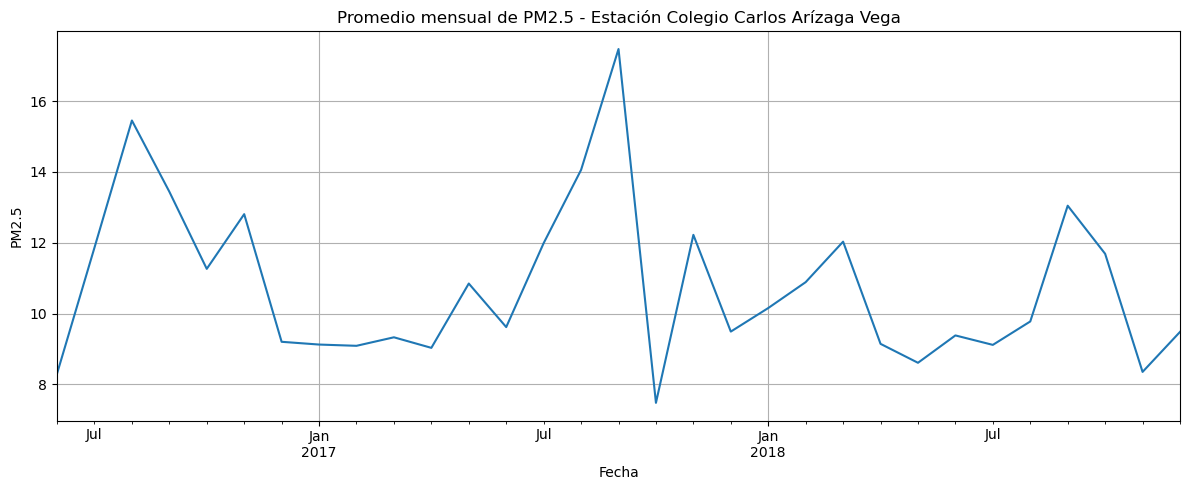

ADF Statistic: -4.41297179606336
p-value: 0.0002815290799020322
Critical Values:
  1%: -3.6699197407407405
  5%: -2.9640707407407407
  10%: -2.621171111111111


In [248]:
# Paso 1: Importar librerías necesarias
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Paso 3: Filtrar datos de la estación Belisario en Pichincha
df_belisario = df[(df['PROV'] == 'Azuay') & (df['ESTACION'] == 'Colegio Carlos Arízaga Vega') & (df['PM2.5'].notna())].copy()

# Paso 4: Agrupar por año-mes y calcular promedio mensual
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()

# Convertir índice a datetime para análisis de series de tiempo
serie_mensual.index = serie_mensual.index.to_timestamp()

# Visualizar la serie
serie_mensual.plot(figsize=(12, 5), title="Promedio mensual de PM2.5 - Estación Colegio Carlos Arízaga Vega")
plt.xlabel("Fecha")
plt.ylabel("PM2.5")
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 5: Prueba ADF (Augmented Dickey-Fuller)
resultado_adf = adfuller(serie_mensual.dropna())

# Paso 6: Mostrar resultados
print("ADF Statistic:", resultado_adf[0])
print("p-value:", resultado_adf[1])
print("Critical Values:")
for key, value in resultado_adf[4].items():
    print(f"  {key}: {value}")

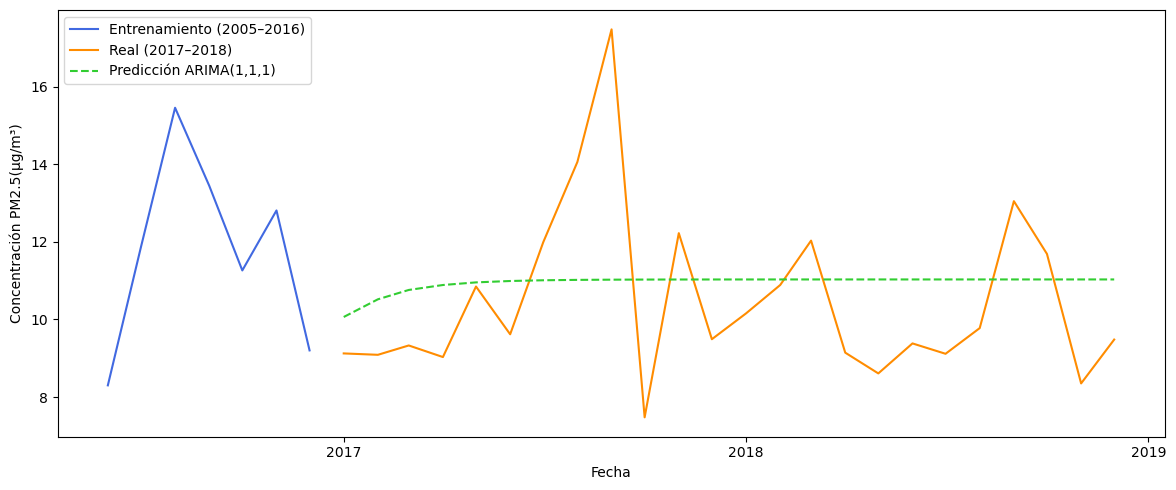

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                    7
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -14.567
Date:                Sun, 15 Jun 2025   AIC                             35.134
Time:                        02:10:03   BIC                             34.509
Sample:                    06-01-2016   HQIC                            32.633
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5291      2.263      0.234      0.815      -3.906       4.965
ma.L1         -0.9993    364.122     -0.003      0.998    -714.666     712.668
sigma2         6.3216   2299.362      0.003      0.9

In [436]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar estación Belisario
df_belisario = df[
    (df['PROV'] == 'Azuay') &
    (df['ESTACION'] == 'Colegio Carlos Arízaga Vega') &
    (df['PM2.5'].notna())
].copy()

# Serie mensual
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar entrenamiento y prueba
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']
serie_test = serie_mensual[serie_mensual.index > '2016-12-01']

# Ajustar modelo ARIMA
modelo = ARIMA(serie_entrenamiento, order=(1,1,1))
modelo_entrenado = modelo.fit()
predicciones = modelo_entrenado.forecast(steps=len(serie_test))
predicciones.index = serie_test.index

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(serie_entrenamiento, label='Entrenamiento (2005–2016)', color='royalblue')
plt.plot(serie_test, label='Real (2017–2018)', color='darkorange')
plt.plot(predicciones, label='Predicción ARIMA(1,1,1)', color='limegreen', linestyle='--')

# Etiquetas y leyenda
#plt.title("Modelo ARIMA(1,1,1) - PM2.5 mensual - Estación Colegio Carlos Arízaga Vega")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2.5(µg/m³)")
plt.legend(loc='upper left')
plt.grid(False)
plt.tight_layout()


# Formatear el eje X para que muestre solo el año
import matplotlib.dates as mdates
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())

plt.show()

# Paso 5: Resumen del modelo
print(modelo_entrenado.summary())

# Métricas
mae = mean_absolute_error(serie_test, predicciones)
rmse = np.sqrt(mean_squared_error(serie_test, predicciones))
r2 = r2_score(serie_test, predicciones)

# Resultados
print("\nModelo final para Colegio Carlos Arízaga Vega:")
print("Parámetros: (1, 1, 1)")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

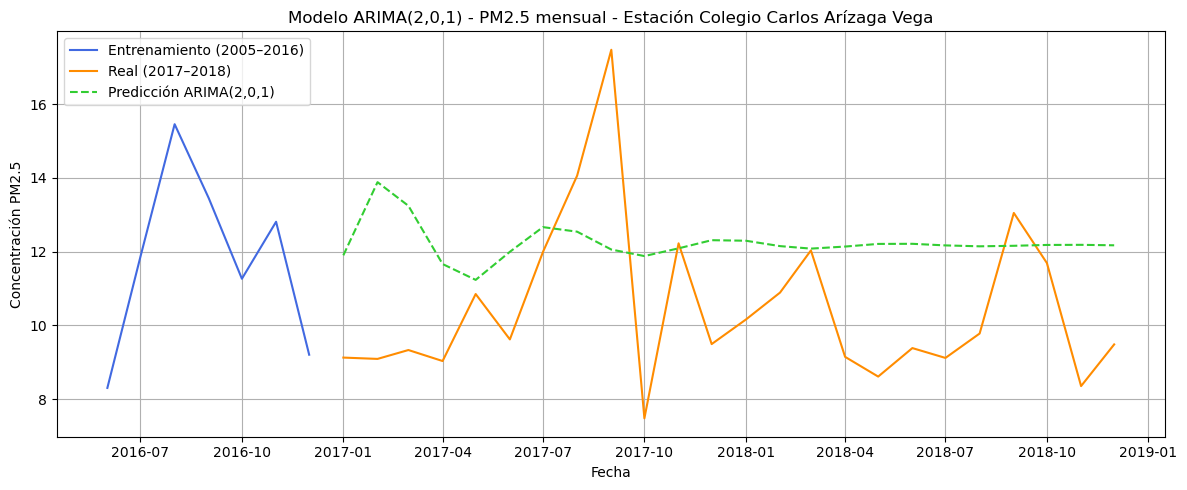

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                    7
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 -14.081
Date:                Wed, 04 Jun 2025   AIC                             38.163
Time:                        23:26:19   BIC                             37.893
Sample:                    06-01-2016   HQIC                            34.820
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.1678      0.888     13.708      0.000      10.428      13.908
ar.L1          0.5264      1.869      0.282      0.778      -3.137       4.189
ar.L2         -0.6255      0.598     -1.046      0.2

In [254]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar estación Belisario
df_belisario = df[
    (df['PROV'] == 'Azuay') &
    (df['ESTACION'] == 'Colegio Carlos Arízaga Vega') &
    (df['PM2.5'].notna())
].copy()

# Serie mensual
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar entrenamiento y prueba
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']
serie_test = serie_mensual[serie_mensual.index > '2016-12-01']

# Ajustar modelo ARIMA
modelo = ARIMA(serie_entrenamiento, order=(2,0,1))
modelo_entrenado = modelo.fit()
predicciones = modelo_entrenado.forecast(steps=len(serie_test))
predicciones.index = serie_test.index

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(serie_entrenamiento, label='Entrenamiento (2005–2016)', color='royalblue')
plt.plot(serie_test, label='Real (2017–2018)', color='darkorange')
plt.plot(predicciones, label='Predicción ARIMA(2,0,1)', color='limegreen', linestyle='--')

# Etiquetas y leyenda
plt.title("Modelo ARIMA(2,0,1) - PM2.5 mensual - Estación Colegio Carlos Arízaga Vega")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2.5")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 5: Resumen del modelo
print(modelo_entrenado.summary())

# Métricas
mae = mean_absolute_error(serie_test, predicciones)
rmse = np.sqrt(mean_squared_error(serie_test, predicciones))
r2 = r2_score(serie_test, predicciones)

# Resultados
print("\nModelo final para Colegio Carlos Arízaga Vega:")
print("Parámetros: (2, 0, 1)")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

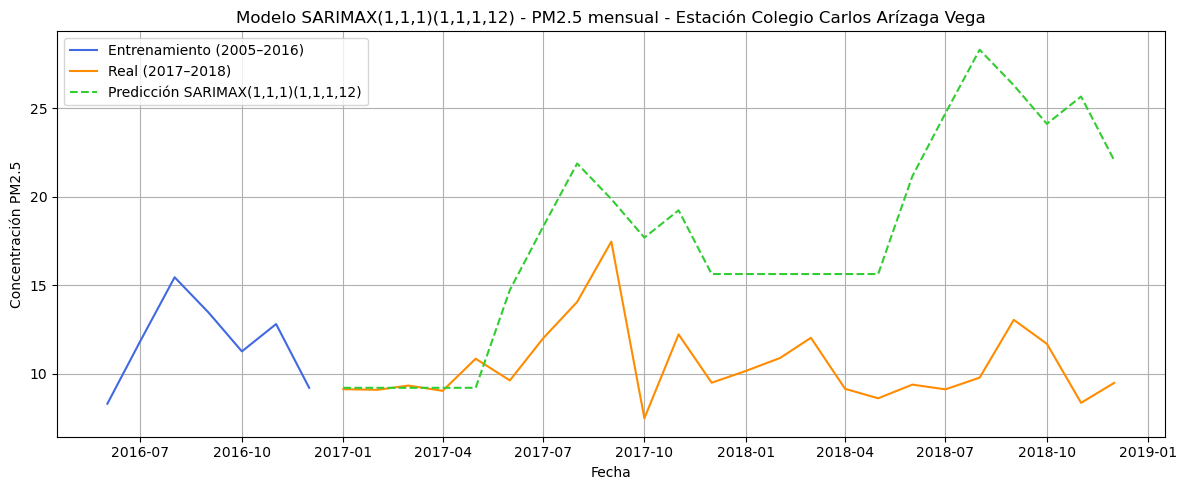

                                     SARIMAX Results                                      
Dep. Variable:                              PM2.5   No. Observations:                    7
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Wed, 04 Jun 2025   AIC                             10.000
Time:                                    23:27:22   BIC                                nan
Sample:                                06-01-2016   HQIC                               nan
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ma.L1               0         -0   

In [256]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar datos para Belisario
df_belisario = df[
    (df['PROV'] == 'Azuay') &
    (df['ESTACION'] == 'Colegio Carlos Arízaga Vega') &
    (df['PM2.5'].notna())
].copy()

# Agrupar por mes
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar en entrenamiento y prueba
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']
serie_test = serie_mensual[serie_mensual.index > '2016-12-01']

# Entrenar modelo SARIMAX
modelo_sarimax = SARIMAX(serie_entrenamiento,
                         order=(1, 1, 1),
                         seasonal_order=(1, 1, 1, 12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)

resultado_sarimax = modelo_sarimax.fit(disp=False)

# Predecir
predicciones = resultado_sarimax.forecast(steps=len(serie_test))
predicciones.index = serie_test.index

# Graficar resultados
plt.figure(figsize=(12, 5))
plt.plot(serie_entrenamiento, label='Entrenamiento (2005–2016)', color='royalblue')
plt.plot(serie_test, label='Real (2017–2018)', color='darkorange')
plt.plot(predicciones, label='Predicción SARIMAX(1,1,1)(1,1,1,12)', color='limegreen', linestyle='--')
plt.title("Modelo SARIMAX(1,1,1)(1,1,1,12) - PM2.5 mensual - Estación Colegio Carlos Arízaga Vega")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2.5")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar resumen del modelo
print(resultado_sarimax.summary())

# Calcular métricas
mae = mean_absolute_error(serie_test, predicciones)
rmse = np.sqrt(mean_squared_error(serie_test, predicciones))
r2 = r2_score(serie_test, predicciones)

# Imprimir resultados
print("\nModelo SARIMAX final para Colegio Carlos Arízaga Vega:")
print("Parámetros: (1, 1, 1) x (1, 1, 1, 12)")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")


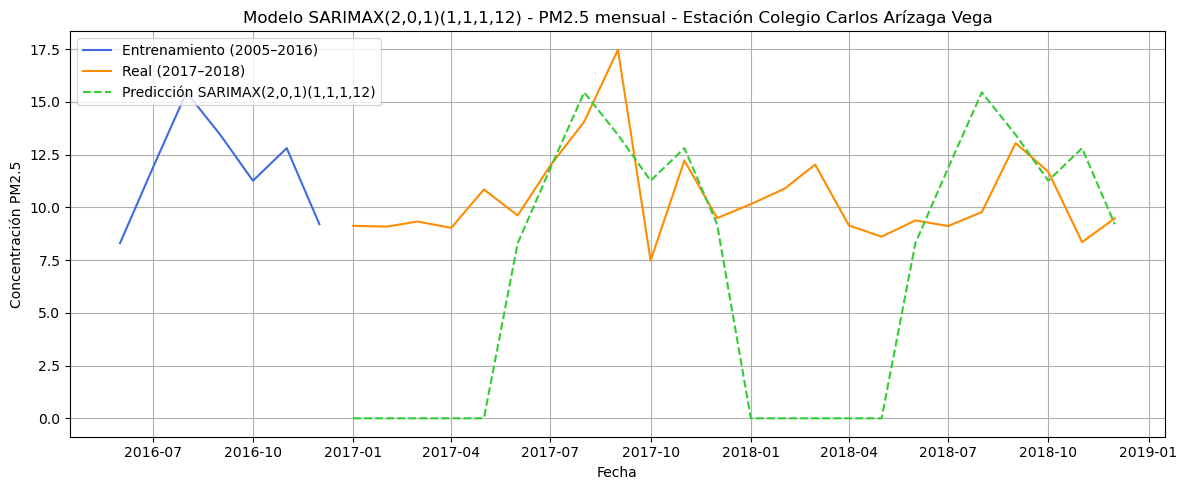

                                     SARIMAX Results                                      
Dep. Variable:                              PM2.5   No. Observations:                    7
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Wed, 04 Jun 2025   AIC                             12.000
Time:                                    23:42:57   BIC                                nan
Sample:                                06-01-2016   HQIC                               nan
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ar.L2               0         -0   

In [270]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

 
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar datos para Belisario
df_belisario = df[
    (df['PROV'] == 'Azuay') &
    (df['ESTACION'] == 'Colegio Carlos Arízaga Vega') &
    (df['PM2.5'].notna())
].copy()

# Agrupar por mes
serie_mensual = df_belisario.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar en entrenamiento y prueba
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']
serie_test = serie_mensual[serie_mensual.index > '2016-12-01']

# Entrenar modelo SARIMAX
modelo_sarimax = SARIMAX(serie_entrenamiento,
                         order=(2, 0, 1),
                         seasonal_order=(1, 1, 1, 12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)

resultado_sarimax = modelo_sarimax.fit(disp=False)

# Predecir
predicciones = resultado_sarimax.forecast(steps=len(serie_test))
predicciones.index = serie_test.index

# Graficar resultados
plt.figure(figsize=(12, 5))
plt.plot(serie_entrenamiento, label='Entrenamiento (2005–2016)', color='royalblue')
plt.plot(serie_test, label='Real (2017–2018)', color='darkorange')
plt.plot(predicciones, label='Predicción SARIMAX(2,0,1)(1,1,1,12)', color='limegreen', linestyle='--')
plt.title("Modelo SARIMAX(2,0,1)(1,1,1,12) - PM2.5 mensual - Estación Colegio Carlos Arízaga Vega")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM2.5")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar resumen del modelo
print(resultado_sarimax.summary())

# Calcular métricas
mae = mean_absolute_error(serie_test, predicciones)
rmse = np.sqrt(mean_squared_error(serie_test, predicciones))
r2 = r2_score(serie_test, predicciones)

# Imprimir resultados
print("\nModelo SARIMAX final para Colegio Carlos Arízaga Vega:")
print("Parámetros: (2, 0, 1) x (1, 1, 1, 12)")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")


In [358]:
 import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Convertir fecha y crear columna de año-mes
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['ANIO_MES'] = df['FECHA'].dt.to_period('M')

# Filtrar la estación específica
df_cuenca = df[
    (df['PROV'] == 'Azuay') &
    (df['ESTACION'] == 'Colegio Carlos Arízaga Vega') &
    (df['PM2.5'].notna())
].copy()

# Agrupar por mes
serie_mensual = df_cuenca.groupby('ANIO_MES')['PM2.5'].mean()
serie_mensual.index = serie_mensual.index.to_timestamp()

# Separar entrenamiento hasta diciembre 2016
serie_entrenamiento = serie_mensual[serie_mensual.index <= '2016-12-01']

# Entrenar modelo ARIMA(1,1,1)
modelo_arima = SARIMAX(serie_entrenamiento,
                       order=(1, 1, 1),
                       seasonal_order=(0, 0, 0, 0),  # Sin estacionalidad
                       enforce_stationarity=False,
                       enforce_invertibility=False)

modelo_entrenado = modelo_arima.fit()

# Predicción para 12 meses de 2023 (puedes ajustar fechas si deseas 2017)
pred = modelo_entrenado.get_forecast(steps=12)
pred_df = pred.summary_frame()

# Ajustar índice de fechas
pred_df.index = pd.date_range(start='2017-01-31', periods=12, freq='M')

# Renombrar columnas
pred_df = pred_df[['mean', 'mean_ci_lower', 'mean_ci_upper']]
pred_df.columns = ['Predicción', 'Límite Inferior', 'Límite Superior']

# Mostrar resultados
print(pred_df.round(6))


            Predicción  Límite Inferior  Límite Superior
2017-01-31   11.325802         7.301974        15.349630
2017-02-28   10.803850         6.515351        15.092349
2017-03-31   10.932064         6.153768        15.710361
2017-04-30   10.900569         5.738168        16.062971
2017-05-31   10.908306         5.375020        16.441592
2017-06-30   10.906405         5.028706        16.784105
2017-07-31   10.906872         4.703126        17.110618
2017-08-31   10.906758         4.393436        17.420079
2017-09-30   10.906786         4.097909        17.715663
2017-10-31   10.906779         3.814663        17.998895
2017-11-30   10.906781         3.542308        18.271253
2017-12-31   10.906780         3.279671        18.533889
